# Machine Learning Projet : Stock Return Prediction

Axel PORTIER, Lucas STALTER, Gaspard SALLURON--BESNARD

# Project Overview

This project aims to predict the direction of residual stock returns in the U.S. market using historical financial data from Qube RT. The goal is to detect weak predictive signals rather than forecast exact prices, focusing on the underlying patterns that drive short-term stock movements once market effects are removed.

The dataset includes 46 numerical features, covering anonymized identifiers (`STOCK, INDUSTRY`, `SECTOR`) and 20-day histories of residual returns (`RET_1`–`RET_20`) and trading volumes (`VOLUME_1`–`VOLUME_20`). The target variable, `RET`, is binary, indicating whether the residual return at time t is positive or negative.

Following a structured machine learning pipeline, we perform data quality checks, feature preprocessing, and correlation analysis, then train both baseline models (e.g., Logistic Regression, Decision Trees) and advanced algorithms (e.g., Random Forest, XGBoost, Neural Networks). Model performance is assessed using F1-score and ROC-AUC, ensuring robust evaluation despite potential class imbalance.

Ultimately, this work explores how machine learning methods can capture meaningful financial patterns to support better decision-making in quantitative trading and risk management.

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import skew, kurtosis
import math

# Phase I QUALITY CHECK & DATA EXPLORATION

The dataset consists of 46 descriptive features, all represented as numerical values (float or integer).

- `DATE` : an anonymized and randomized date index, without temporal continuity or sequential dependency.

- `STOCK` : an identifier representing the stock.

- `INDUSTRY`, `INDUSTRY_GROUP`, `SUB_INDUSTRY`, `SECTOR`: hierarchical categorical indices describing the economic domain of each stock (e.g., aeronautics, IT, oil, etc.).

- `RET_1` to `RET_20`: historical residual returns over the last 20 days, where `RET_1` corresponds to the previous day’s residual return, `RET_2` to two days before, and so on.

- `VOLUME_1` to `VOLUME_20`: historical relative trading volumes over the last 20 days, where `VOLUME_1` is the volume of the previous day.

The target variable, `RET`, is binary and represents the sign of the residual stock return at time t (i.e., positive or negative).

In the initial phase, the analysis focuses on understanding the dataset’s structure — specifically investigating missing values, class balance, and potential correlations among features.

### In the dataset we must acknowledge this : SUB INDUSTRY ⊂ INDUSTRY ⊂ INDUSTRY_GROUP ⊂ SECTOR 

## I) Data Loading & Initial Verification

In [2]:
x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1) #axis = 1 concat by columns
test = pd.read_csv('./x_test.csv', index_col='ID')
print(train.columns)
train.head()

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET'],
      dtype='object')


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


### Dataset features's types

In [3]:
train.info()
train.dtypes.value_counts()


<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6       

float64    40
int64       6
bool        1
Name: count, dtype: int64

### Type of the target

In [4]:
print(train['RET'].value_counts(normalize=True))
print(train['RET'].dtype)


RET
False    0.501079
True     0.498921
Name: proportion, dtype: float64
bool


The target variable `RET` is well balanced, with approximately 50.1% False and 49.9% True values, indicating no significant class imbalance in the dataset. However, to experiment with different approaches, we will still address the imbalance problem later in the project.

### Dataset's dimensions :

In [5]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()
train.describe(include='all')

Train shape: (418595, 47)
Test shape: (198429, 46)


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,416236.000000,353570.000000,416130.000000,352209.000000,...,351333.000000,413294.000000,356281.000000,413288.000000,351009.000000,413282.000000,351266.000000,413254.000000,350738.000000,418595
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209749
mean,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001383,-0.071502,0.000973,-0.075230,...,-0.076018,0.001642,-0.087854,0.001131,-0.076147,-0.000798,-0.076496,-0.000027,-0.076337,NaN
std,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031311,3.038658,0.030987,2.635549,...,2.185741,0.031914,2.094459,0.031435,2.423121,0.030738,2.229668,0.033347,2.721355,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,-3.007262,...,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928,NaN
25%,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010970,-0.555394,-0.011312,-0.540629,...,-0.533574,-0.011331,-0.552613,-0.010949,-0.539491,-0.012139,-0.527846,-0.011682,-0.542790,NaN
50%,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000637,-0.282609,0.000401,-0.278437,...,-0.272271,0.000433,-0.285480,0.000000,-0.281753,0.000000,-0.277674,0.000000,-0.283405,NaN
75%,161.000000,4606.000000,53.000000,19.000000,7.000000,128.000000,0.012950,0.047759,0.012326,0.041177,...,0.029131,0.012862,0.027272,0.012180,0.027639,0.011236,0.030201,0.011712,0.035795,NaN


# II) Data Processing

### From now on, we are gonna work on the train by the intermediary of the ***cleaning_train*** dataset in order to clearly seperate both

For simplicity and computational efficiency in testing and throughout the rest of the project, we will focus on **the last 10 days** of returns and volumes.

In [6]:
# to_drop = [f'RET_{day}' for day in range(11,21)]
# to_drop += [f'VOLUME_{day}' for day in range(11,21)]
# cleaning_train = train.drop(columns= to_drop).copy()
cleaning_train = train.copy()

## II.1) Missing values analysis

In [7]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100 # percentage of nan values per feature (axis=0 : each nbr of nan for each features)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.563552
VOLUME_1          15.534108
RET_2              0.588875
VOLUME_2          15.859243
RET_3              0.598908
VOLUME_3          16.201579
RET_4              0.607747
VOLUME_4          16.960785
RET_5              0.617303
VOLUME_5          17.843739
RET_6              0.620409
VOLUME_6          17.848756
RET_7              0.617542
VOLUME_7          17.643068
RET_8              0.626620
VOLUME_8          17.653818
RET_9              0.640715
VOLUME_9          17.510481
RET_10             0.643104
VOLUME_10         17.512154
RET_11             0.707366
VOLUME_11         17.206369
RET_12             0.761118
VOLUME_12         14.936394
RET_13             0.802685
VOLUME_13         14.096681
RET_14             1.054241
VOLUME_14         14.555597
RET_15             1.192083
VOLUME_15         15

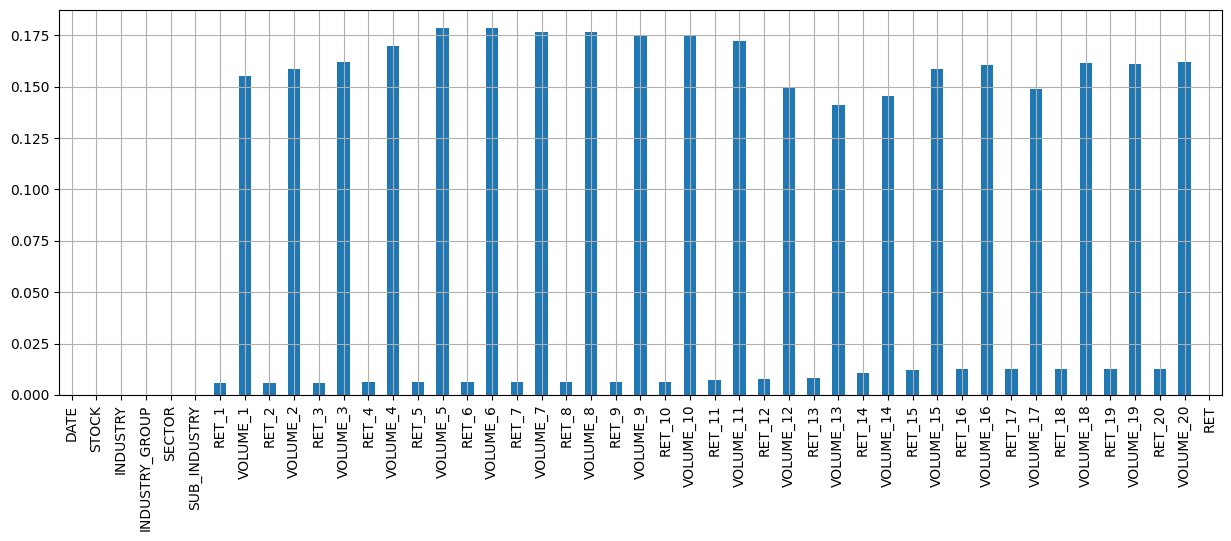

In [8]:
nb_missing = cleaning_train.isna().sum()
rate_missing = nb_missing / cleaning_train.index.nunique()

fig, ax = plt.subplots(figsize=(15,5))
rate_missing.plot(kind="bar", ax=ax)

ax.grid()
plt.xticks(rotation=90)
plt.show()


Most of the missing values are concentrated in the `VOLUME_1`..., with around **15% missing data**, which represents a considerable proportion. 
Consequently, a specific step will be devoted later to addressing these missing values.
It is also import to hightlight that there is no missing values in the `SECTOR` etc.

### Percentage of missing values for each unique value within  `INDUSTRY`, `INDUSTRY_GROUP`, `SECTOR`, `SUB_INDUSTRY`, `STOCK`, and `DATE`.

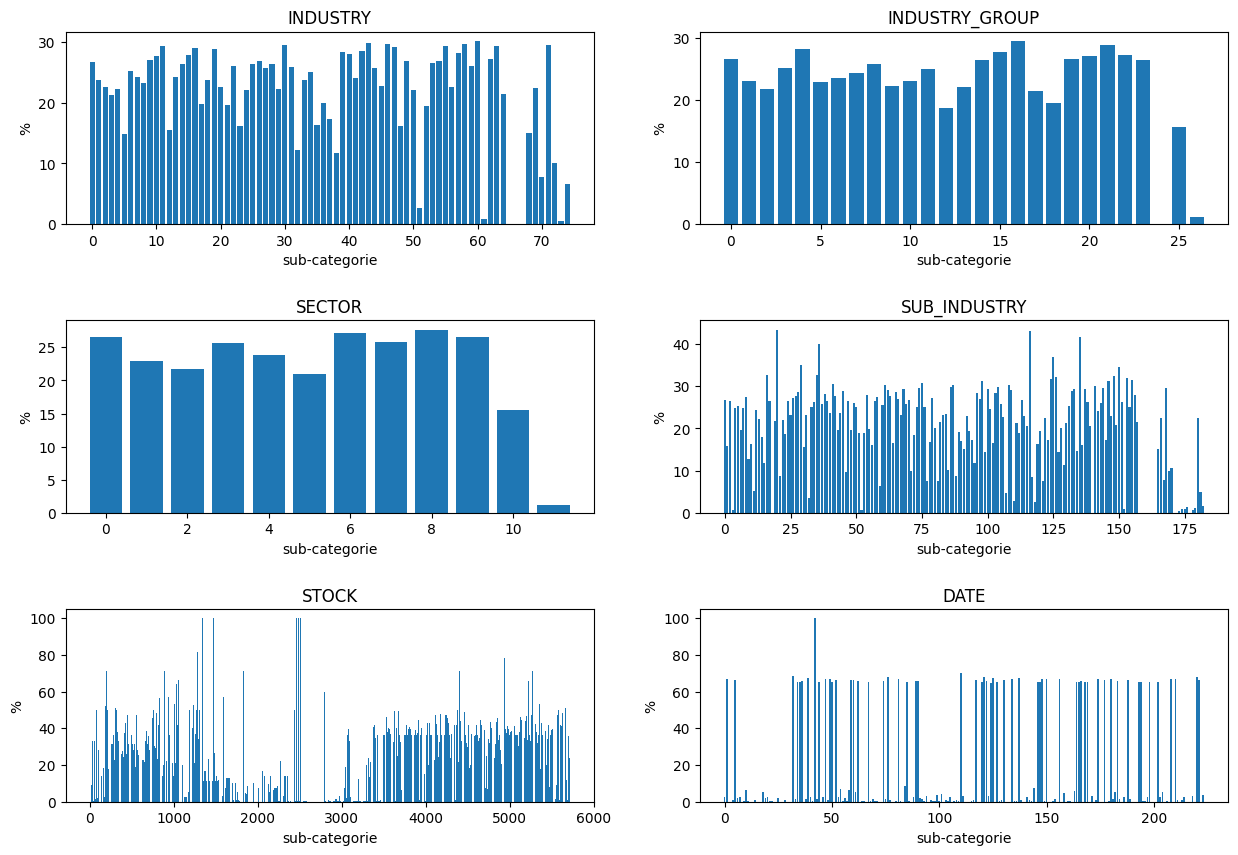

In [9]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i,categorie in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(3,2,i+1)
    plt.title(categorie)
    X_absciss = cleaning_train[categorie].sort_values().unique()

    unique_Y_values = cleaning_train[categorie].sort_values().unique()
    Y_absciss = [(cleaning_train[cleaning_train[categorie]==sub_categorie].isna().sum(axis=1)>0).sum()/len(cleaning_train[cleaning_train[categorie]==sub_categorie])*100 for sub_categorie in unique_Y_values]
    
    plt.bar(X_absciss,Y_absciss)
    plt.xlabel('sub-categorie')
    plt.ylabel('%')
plt.show()

The plots display the percentage of NaN values per subcategory. We observe a relatively even distribution of missing values for the categorical variable SECTOR, whereas the amount of missing data in other categorical features appears less uniform.

It may be useful to investigate whether some rows mainly consist of missing values in the descriptive variables (RET and VOLUME). If that is the case, those observations can reasonably be removed, as they do not contribute meaningful information to the model.

We will first **remove rows with heavy missingness**, then **impute minor gaps** with consistent values.

### Let's remove the rows where half or more of their features `RET_` and `VOL_` are NaN

In [10]:
ret_features = [f'RET_{day}' for day in range(1,11)]
vol_features = [f'VOLUME_{day}' for day in range(1,11)]
features = vol_features + ret_features

to_drop = cleaning_train[cleaning_train[features].isna().sum(axis=1) >= len(features)*0.5][features].index
nb_drop = len(to_drop)
nb_rows = len(cleaning_train)
print(
    f"Number of rows before removing: {nb_rows}\n"
    f"Number of rows removed: {nb_drop}\n"
    f"Overall ratio (% of rows removed): {nb_drop / nb_rows * 100:.4f}%"
)


cleaning_train.drop(index = to_drop, axis=0, inplace = True)

Number of rows before removing: 418595
Number of rows removed: 54607
Overall ratio (% of rows removed): 13.0453%


About 13% of the rows were less than half complete, which is a significant proportion and an important aspect to take into account during data cleaning.

In [11]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.001923
VOLUME_1           2.862182
RET_2              0.002747
VOLUME_2           3.236096
RET_3              0.001923
VOLUME_3           3.629790
RET_4              0.001374
VOLUME_4           4.502896
RET_5              0.000824
VOLUME_5           5.518589
RET_6              0.000549
VOLUME_6           5.524633
RET_7              0.000000
VOLUME_7           5.287812
RET_8              0.000000
VOLUME_8           5.300449
RET_9              0.000000
VOLUME_9           5.136983
RET_10             0.000275
VOLUME_10          5.139730
RET_11             0.015110
VOLUME_11          5.719145
RET_12             0.060716
VOLUME_12          5.779311
RET_13             0.077475
VOLUME_13          6.734563
RET_14             0.288746
VOLUME_14          8.720342
RET_15             0.324187
VOLUME_15         10

From now on the stat of missing values are lower, but let's keep digging that way by replacing the missing values

### Before that let's have a look at the features distributions

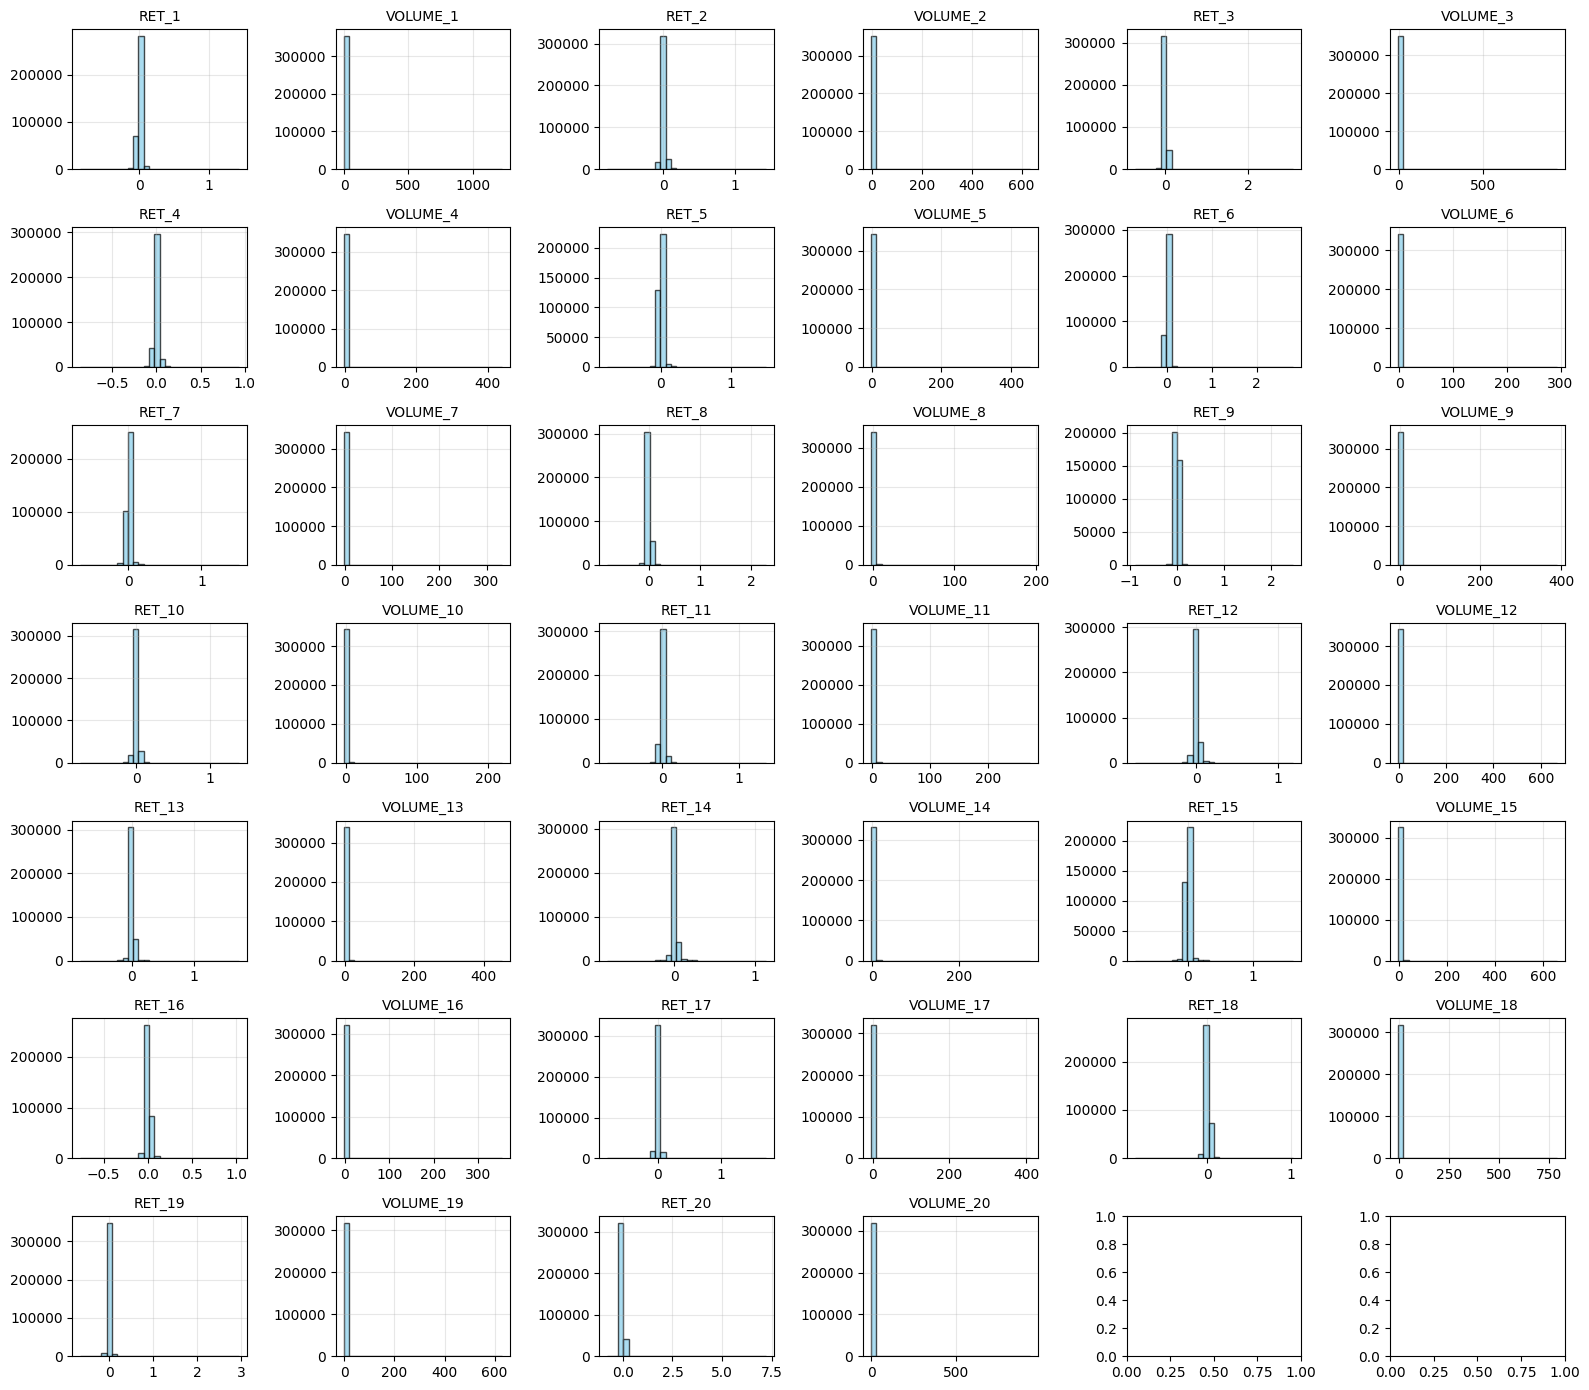

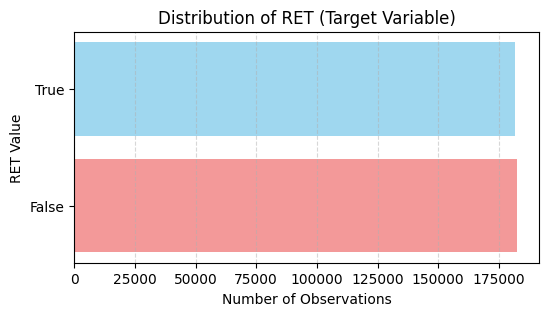

In [12]:
features = [col for col in cleaning_train.columns if col not in ["INDUSTRY", "INDUSTRY_GROUP", "SECTOR", "SUB_INDUSTRY", "STOCK", "DATE","RET"]]
n_cols = 6
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
axes = axes.flatten()

for i, feature in enumerate(features):
    cleaning_train[feature].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(feature, fontsize=10)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

ret_counts = cleaning_train["RET"].value_counts()
plt.figure(figsize=(6, 3))
plt.barh(ret_counts.index.astype(str), ret_counts.values, color=["lightcoral", "skyblue"], alpha=0.8)
plt.title("Distribution of RET (Target Variable)")
plt.xlabel("Number of Observations")
plt.ylabel("RET Value")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


The plots are not very meaningful since most values are centered around 0. This is consistent with the nature of the data: we are dealing with relative volumes and residual returns, which are either normalized or expressed relative to market behavior after removing overall market effects. Nevertheless, it is interesting to note that the RET values are fairly well balanced.

In [13]:
volume = pd.DataFrame(columns=['day', 'ret_mean', 'ret_median', 'ret_std', 'vol_mean', 'vol_median', 'vol_std'])
for day in range(1,11):
    volume.loc[day] =[day, cleaning_train[f'RET_{day}'].mean(), cleaning_train[f'RET_{day}'].median(), cleaning_train[f'RET_{day}'].std(), 
                      cleaning_train[f'VOLUME_{day}'].mean(), cleaning_train[f'VOLUME_{day}'].median(), cleaning_train[f'VOLUME_{day}'].std()]
volume

,day,ret_mean,ret_median,ret_std,vol_mean,vol_median,vol_std
1,1.0,0.001656,0.000814,0.030582,-0.071502,-0.282609,3.038658
2,2.0,0.001353,0.000876,0.030159,-0.075230,-0.278437,2.635549
3,3.0,0.002575,0.001251,0.030920,-0.097235,-0.278277,2.490831
4,4.0,-0.001089,-0.000636,0.029817,-0.088976,-0.275435,1.730786
5,5.0,0.000765,0.000000,0.031250,-0.092162,-0.281238,1.848980
6,6.0,-0.000166,0.000000,0.030534,-0.100509,-0.288125,1.689070
7,7.0,0.000240,0.000000,0.030233,-0.084719,-0.284789,1.839735
8,8.0,-0.000407,-0.000446,0.030708,-0.087038,-0.289772,1.595810
9,9.0,-0.000891,-0.000233,0.032157,-0.090856,-0.298185,1.857252
10,10.0,0.000397,0.000000,0.030469,-0.092194,-0.295754,1.653336


### Missing Value Imputation Choice for `VOL_`

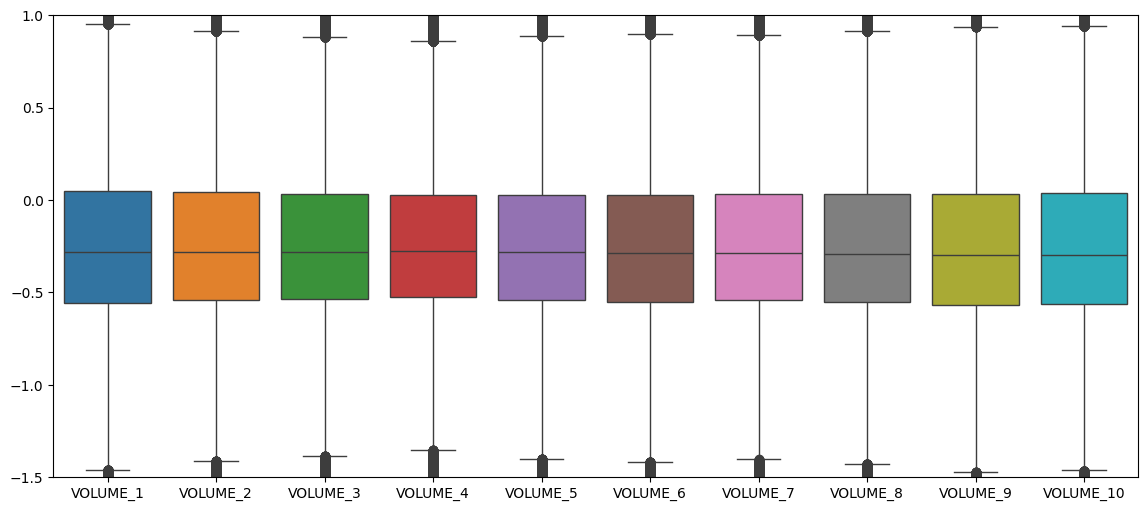

In [14]:
plt.figure(figsize=(14, 6))  # largeur = 20, hauteur = 6
sns.boxplot(cleaning_train[[f'VOLUME_{day}' for day in range(1,11)]])
plt.ylim((-1.5,1))
plt.show()

### Justification for Missing-Value Imputation (Volumes)

**A quick reminder — what is skewness?**  
Skewness describes the *asymmetry* of a distribution:  
- **Symmetric**: left and right tails are similar; mean ≈ median.  
- **Left-skewed (negative skew)**: longer/larger tail on the left; **mean < median**.  
- **Right-skewed (positive skew)**: longer/larger tail on the right; **mean > median**.  

**What we observe for `VOLUME_1`–`VOLUME_10`:**  
- The **median is around −0.25** across all volume features (i.e., slightly shifted left, not centered at 0, and showing **no extreme skew**).  
- Outliers exist but are not dominant, and we will handle them later.  

**Why we impute with the median:**  
- The **median is robust** to outliers, unlike the mean, which is affected by them.  
- Therefore, based on our boxplots, imputing with the **mean** would be too optimistic and could distort the true distribution.



In [15]:
per_feature_median_volume = cleaning_train[vol_features].median()
print(per_feature_median_volume)
cleaning_train[vol_features] = cleaning_train[vol_features].fillna(per_feature_median_volume)


VOLUME_1    -0.282609
VOLUME_2    -0.278437
VOLUME_3    -0.278277
VOLUME_4    -0.275435
VOLUME_5    -0.281238
VOLUME_6    -0.288125
VOLUME_7    -0.284789
VOLUME_8    -0.289772
VOLUME_9    -0.298185
VOLUME_10   -0.295754
dtype: float64


### Missing Value Imputation Choice for `RET_`

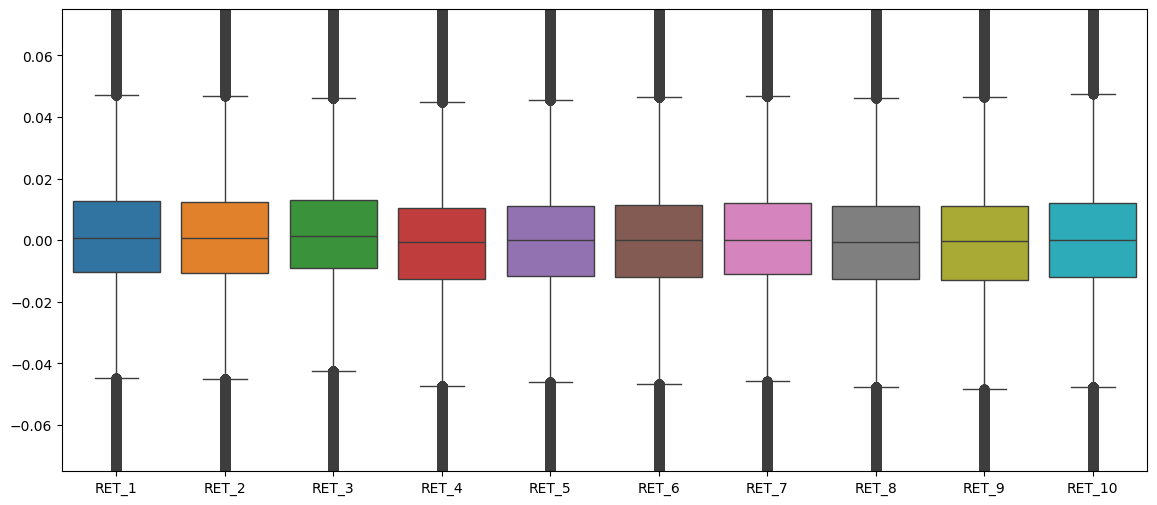

In [16]:
plt.figure(figsize=(14, 6))  # largeur = 20, hauteur = 6
sns.boxplot(cleaning_train[[f'RET_{day}' for day in range(1,11)]])
plt.ylim((-0.075,0.075))
plt.show()

For the `RET_` features, the **median is close to 0**, indicating a symmetric distribution around the center.  
Although imputing missing values with the **mean** could be appropriate in this case, we will use the **median** instead to remain consistent with a **robust imputation strategy** less sensitive to potential outliers.


In [17]:
per_feature_median_return  = cleaning_train[ret_features].median()
print(per_feature_median_return)
cleaning_train[ret_features] = cleaning_train[ret_features].fillna(per_feature_median_return)

RET_1     0.000814
RET_2     0.000876
RET_3     0.001251
RET_4    -0.000636
RET_5     0.000000
RET_6     0.000000
RET_7     0.000000
RET_8    -0.000446
RET_9    -0.000233
RET_10    0.000000
dtype: float64


### Just checking that all the features are well imputated

In [18]:
cleaning_train.isna().sum(axis = 0)/len(cleaning_train)*100

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.000000
VOLUME_1           0.000000
RET_2              0.000000
VOLUME_2           0.000000
RET_3              0.000000
VOLUME_3           0.000000
RET_4              0.000000
VOLUME_4           0.000000
RET_5              0.000000
VOLUME_5           0.000000
RET_6              0.000000
VOLUME_6           0.000000
RET_7              0.000000
VOLUME_7           0.000000
RET_8              0.000000
VOLUME_8           0.000000
RET_9              0.000000
VOLUME_9           0.000000
RET_10             0.000000
VOLUME_10          0.000000
RET_11             0.015110
VOLUME_11          5.719145
RET_12             0.060716
VOLUME_12          5.779311
RET_13             0.077475
VOLUME_13          6.734563
RET_14             0.288746
VOLUME_14          8.720342
RET_15             0.324187
VOLUME_15         10

Alright, the missing values have been successfully replaced using the median strategy.  
We can now move on to the **outlierss**, where we will different methods in order to remove them.


## II.3) Outliers handling

### IQR Method

Nb lignes supprimées IQR : 134723, equivalently to 37.0% of total dataset


(-0.05, 0.05)

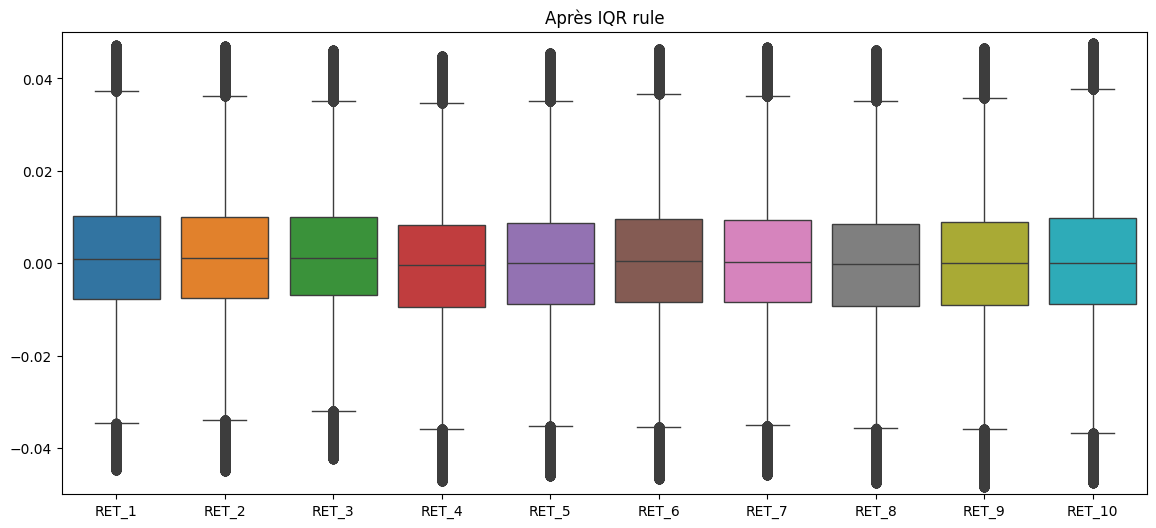

In [19]:
features = ret_features + vol_features
X = cleaning_train[ret_features]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
mask_iqr = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
cleaning_train_iqr = cleaning_train[mask_iqr]

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iqr)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")
plt.figure(figsize=(14, 6))
sns.boxplot(cleaning_train_iqr[ret_features])
plt.title("Après IQR rule")
plt.ylim((-0.05, 0.05))

The **Interquartile Range (IQR) rule** was applied to detect and remove outliers in the `RET_` features.  

$$
\text{Lower bound} = Q1 - 1.5 \times IQR
$$
$$
\text{Upper bound} = Q3 + 1.5 \times IQR
$$

$$ IQR = Q3 - Q1 $$

This method identifies values lying beyond **1.5 × IQR** from the first (Q1) and third (Q3) quartiles.  
After applying this rule, the overall distribution of returns remains consistent, with medians close to 0 and fewer extreme values.  
This confirms that the 37% removed observations were genuine outliers, allowing for a **cleaner and more stable dataset** while preserving the main statistical structure.

### IsolationForest Method

Nb lignes supprimées IQR : 18200, equivalently to 5.0% of total dataset


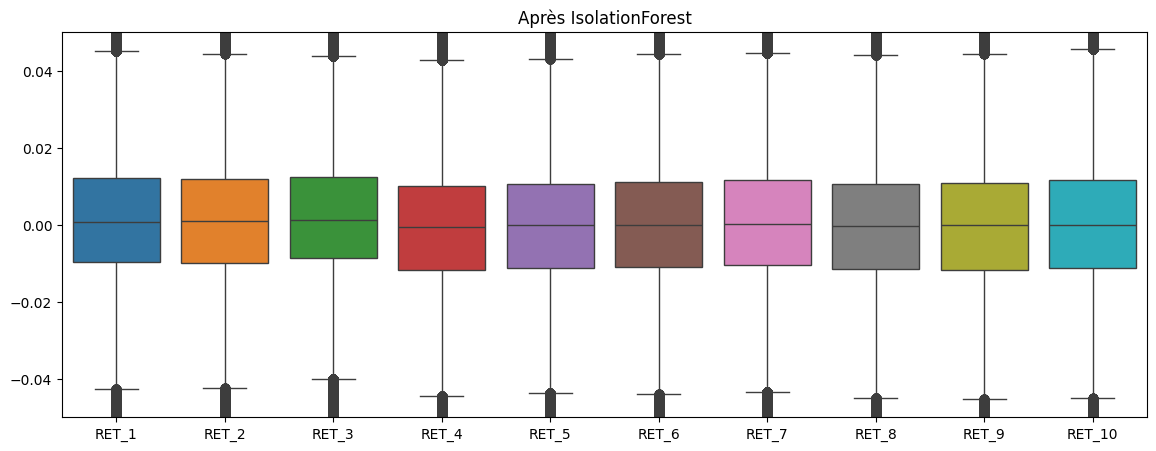

In [20]:
# --- Méthode 2 : IsolationForest ---
iso = IsolationForest(contamination=0.05, random_state=42)
y_pred_iso = iso.fit_predict(X)
cleaning_train_iso = cleaning_train[y_pred_iso == 1]  # 1 = normal, -1 = outlier

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iso)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")

plt.figure(figsize=(14, 5))
sns.boxplot(cleaning_train_iso[ret_features])
plt.title("Après IsolationForest")
plt.ylim((-0.05, 0.05))

plt.show()

The **Isolation Forest** algorithm is a model-based method for outlier detection.  
Unlike the IQR rule, which relies on fixed statistical thresholds, Isolation Forest identifies anomalies by **isolating observations** that differ significantly from the majority.  
It works by randomly selecting features and split values to construct multiple decision trees, and the **number of splits required to isolate a point** determines how “anomalous” it is:  
- **Normal points** require many splits (they are deeply nested).  
- **Outliers** are isolated quickly (few splits needed).  

In this analysis, we applied Isolation Forest with a contamination rate of **5%**, meaning the model assumes roughly 5% of the data could be anomalous.  

After applying the method, the **overall structure of the `RET_` features remains stable**, with medians still around 0 and distributions symmetric.  
This indicates that the algorithm primarily removed **a small proportion of extreme or inconsistent observations**, improving dataset quality without distorting its core statistical behavior.  
Overall, the data is now cleaner and more consistent for subsequent modeling steps.


## II.4) Imbalanced Data handling

In [21]:
print(cleaning_train['RET'].value_counts(normalize=True)*100)
print(cleaning_train_iso['RET'].value_counts(normalize=True)*100)
print(cleaning_train_iqr['RET'].value_counts(normalize=True)*100)

RET
False    50.131872
True     49.868128
Name: proportion, dtype: float64
RET
False    50.095145
True     49.904855
Name: proportion, dtype: float64
RET
True     50.679781
False    49.320219
Name: proportion, dtype: float64


# III) Feature Engineering

In [22]:
new_features = []
frames = [cleaning_train_iso.copy(), cleaning_train_iqr.copy(), test.copy()]

## `RET_{shift}_SECTOR_DATE_stat`

In [23]:
shifts = [1,2,3,4] 
statistics = ['mean']
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['RET']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in frames:
                    data[name] = data.groupby(gb_features)[feat].transform(stat)

This block creates new features like `RET_{shift}_SECTOR_DATE_mean` for each return lag (1–4).

For every (`SECTOR`, `DATE`) group, it computes the mean of the shifted return and assigns it to all rows in that group using groupby().transform('mean').\
It’s applied to both train and test to capture average sector-level performance on each date.

## `RET_STOCK_WEEK_{week}_stat`

In [24]:
# This cell includes some statistics that did not improve the accuracy and were not used further
weeks = 2
statistics = ['mean', 'std']
gb_features_list = [['STOCK', 'DATE']]

target_features = ['RET', 'VOLUME'] 
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for stat in statistics:
            for week in range(weeks):
                name = f'{stat}_{target_feature}_STOCK_WEEK_{week+1}'
                new_features.append(name)
                for data in frames:
                    if stat == 'mean':
                        if target_feature == 'VOLUME':
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1).abs()
                        else:
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1)
                    elif stat == 'std':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].std(axis=1)
                    elif stat == 'min':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].min(axis=1)
                    elif stat == 'max':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].max(axis=1)
                    elif stat == 'median':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].median(axis=1)

**Under the assumption, that 1 week = 5 days**

This block creates new features like `RET_STOCK_WEEK_{week}_mean` and `VOLUME_STOCK_WEEK_{week}_std` for four consecutive weeks.\
For each week, it computes the mean or standard deviation of the previous five daily lags (5 days per week) for `RET_` and `VOLUME_`.\
It’s applied to both train and test to capture short-term stock-level trends and volatility patterns.

## Stock's volume compared to its sector

In [25]:
shifts = [1,2] 
statistics = ['sum']
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_VOLUME_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_VOLUME_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in frames:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

Next, I implement the relative measure of the stock's volume compared to its sector. It is similar to normalization.\
This block creates features like `VOLUME_STOCK_WEEK_{shift}_mean/total_VOLUME_of_SECTOR_DATE` for shifts 1–4.\
For each (`SECTOR`, `DATE`) group, it divides each stock’s shifted weekly volume by the group’s total volume using groupby().transform('sum').\
It’s applied to both train and test to capture each stock’s relative share of sector trading activity.\

## Return's volume compared to its sector

In [26]:
shifts = [1,2] 
statistics = ['sum'] 
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_RET_STOCK_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_RET_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in frames:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

## `RET_10_day_momentum / VOLUME_10_day_momentum`

In [27]:
weeks = [2]
targets = ['RET', 'VOLUME']

for target in targets:
    for week in weeks: 
        window_size = 5*week
        name = f'{target}_{window_size}_day_momentum'
        new_features.append(name)
        for data in frames:
            _data = data.copy()
            rolling_mean_target = _data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(2, window_size+1)]].mean()
            target_1_mean = _data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_1']].mean()
            target_1_mean_aligned, rolling_mean_target_aligned = target_1_mean.align(rolling_mean_target, axis=0, level='SECTOR')
            target_momentum = target_1_mean_aligned.sub(rolling_mean_target_aligned.mean(axis=1), axis=0)
            target_momentum.rename(columns={f'{target}_1': name},inplace=True)
            placeholder = _data.join(target_momentum, on=['SECTOR', 'DATE'], how='left')
            data[name] = placeholder[name]

We add a more dynamic feature, called residual return momentum. We do so by calculating the average return over day D-1,...,D-10 and subtract the return of day D to obtain an idea where our stock might go. The residual return momentum reflects recent performance trends.\
This block creates features like `RET_10_day_momentum` and `VOLUME_10_day_momentum`.\
For each (`SECTOR`, `DATE`) group, it compares the most recent day’s average (target_1) to the mean of the previous 10 days to measure short-term momentum.\
It’s applied to both train and test to capture recent performance shifts or activity surges within each sector.\

## `10_day_mean_RET_vola / 10_day_mean_VOLUME_vola`

In [28]:
weeks = [2]
targets = ['RET', 'VOLUME']

for week in weeks: 
    window_size = 5*week
    for target in targets: 
        name = f'{window_size}_day_mean_{target}_vola'
        new_features.append(name)
        for data in frames:
            rolling_std_target = data.groupby(by=['SECTOR', 'DATE'])[[f'{target}_{day}' for day in range(1,window_size+1)]].mean().std(axis=1).to_frame(name)
            placeholder = data.join(rolling_std_target, on=['SECTOR', 'DATE'], how='left')

Compute the standard deviation of the averages to measure volatility (conditioned on sector).\
This block computes the average volatility of `RET_` and `VOLUME_` over the past 10 days within each (`SECTOR`, `DATE`) group.\
It calculates the standard deviation of the 10-day rolling mean to capture short-term fluctuations.\
Applied to all datasets, it reflects recent instability or variability in returns and trading volumes.\

## `RSI_SECTOR_DATE_20`

In [29]:
targets = ["RET"]
window_size = 10
name = f"RSI_SECTOR_DATE_{window_size}"
new_features.append(name)

for target in targets:
    for data in frames:
        _data = data.copy()
        avg_gain_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x>0].mean(), axis=1)
        avg_loss_sector_day = _data.groupby(by=['SECTOR', 'DATE'])[[f'{"RET"}_{day}' for day in range(1, window_size+1)]].mean().agg(lambda x: x[x<0].mean(), axis=1).abs()
        rs_sector_day = avg_gain_sector_day/avg_loss_sector_day
        rsi_sector_date = 100 - 100/(1+rs_sector_day)
        placeholder = _data.join(rsi_sector_date.to_frame(name), on=['SECTOR', 'DATE'], how='left')
        data[name] = placeholder[name]

We are now going to add the relative strength index per sector. The RSI measures the speed and change of price movements.
This block computes a 20-day sector-level Relative Strength Index (RSI) based on RET.
For each (`SECTOR`, `DATE`) group, it calculates the average gains and losses over the past 20 days, derives the relative strength ratio, and converts it into an RSI value.
Applied to all datasets, it captures short-term momentum intensity and potential overbought or oversold conditions within each sector.

## `Sum_ADL`

In [30]:
window_size = 5
name = 'Sum_ADL'
new_features.append(name)

for data in frames:
    _data = data.copy()
    sum_adl = ((_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x>0).sum()) - (_data.groupby(by=["SECTOR", "DATE"])[[f'RET_{day}' for day in range(1, window_size+1)]]).apply(lambda x: (x<0).sum())).sum(axis=1)
    placeholder = _data.join(sum_adl.to_frame(name), on=['SECTOR', 'DATE'], how='left')
    data[name] = placeholder[name]

$ \text{ADL}_{\text{sum}} = \sum_i \text{Net\_Advances}_i $ — *(signals overall market trends)*

where
$ \text{Net\_Advances}_i = \text{Advances}_i − \text{Declines}_i $

$ \text{Advances}_i $ → number of assets for each (`SECTOR`, `DATE`) group with positive returns on day $i$\
$ \text{Declines}_i $ → number of assets for each (`SECTOR`, `DATE`) group with negative returns on day $i$

This block computes a 5-day Advance–Decline Line (ADL) indicator for each (`SECTOR`, `DATE`) group.\
It counts the number of positive (`RET_` > 0) and negative (`RET_` < 0) returns over the past 5 days and takes their difference.\
Applied to all datasets, it measures short-term market breadth within each sector, indicating whether gains or losses dominate.\

In [31]:
print(frames[0].columns)

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## Features independent of sectors ...

(Basic Features): This cell creates foundational features that capture raw market behavior patterns. We compute absolute returns to measure price movement magnitude regardless of direction, realized volatility over 20 days which quantifies market uncertainty and risk, volume ratios to detect unusual trading activity, and return skewness to identify asymmetric price distributions. These features are essential because machine learning models need numerical representations of market dynamics. Absolute returns matter because extreme price moves tend to revert to mean values. Volume ratios signal informed traders entering positions. Skewness identifies distributions with heavy tails predicting larger future moves.


We create abs_ret_1 = |RET_1|, abs_ret_mean_5d = mean(|RET_1|,...,|RET_5|), realized_vol_20d = std(RET_1,...,RET_20) which measures return dispersion over 20 days, vol_ratio = mean(VOLUME_1,...,VOLUME_5) / mean(VOLUME_6,...,VOLUME_20) which compares recent vs historical volume, and ret_skewness = skewness(RET_1,...,RET_20) which measures distribution asymmetry indicating tail risk. The reason we compute these is that financial returns aren't normally distributed and extreme moves (high skewness) often mean-revert fast. Volume ratio identifies when traders suddenly increase or decrease activity which predicts big price moves.


In [32]:
for data in frames :
    # Add features to the copy
    data['abs_ret_1'] = data['RET_1'].abs()
    data['abs_ret_mean_5d'] = data[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].abs().mean(axis=1)
    data['realized_vol_20d'] = data[[f'RET_{i}' for i in range(1, 21)]].std(axis=1)
    data['vol_ratio'] = data['VOLUME_1'] / data[[f'VOLUME_{i}' for i in range(2, 6)]].mean(axis=1)

    # Do the same for test
    data['abs_ret_1'] = data['RET_1'].abs()
    data['abs_ret_mean_5d'] = data[['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']].abs().mean(axis=1)
    data['realized_vol_20d'] = data[[f'RET_{i}' for i in range(1, 21)]].std(axis=1)
    data['vol_ratio'] = data['VOLUME_1'] / data[[f'VOLUME_{i}' for i in range(2, 6)]].mean(axis=1)

    # Verification: train is untouched
    print(data.columns)


Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

This cell extracts advanced volatility measures that traditional models miss. We build six features:

**rolling_vol_10d**: $\text{std}(RET_1, ..., RET_{10})$

**rolling_vol_20d**: $\text{std}(RET_1, ..., RET_{20})$

**parkinson_vol** uses $\sigma_P = \frac{\ln(\max(RET) / \min(RET))}{2 \sqrt{\ln(2)}}$ to capture volatility via range only.

**atr_proxy**: mean of $|RET_i - RET_{i-1}|$

**vol_of_vol**: $\text{std}([\text{std}(RET_{1:5}), \text{std}(RET_{2:6}), ...])$

**range_normalized**: $\frac{\max(RET) - \min(RET)}{|RET_1|}$

These matter because high volatility precedes mean reversals, low volatility suggests trend continuation, and volatility clustering creates windows of risk concentration.


## `rolling_vol_10d & rolling_vol_20d`
Specifies rolling volatility over 10 & 20 days.

In [33]:
"""
Rolling volatility over different windows + Parkinson + ATR + Volatility of volatility + Normalized range
"""
for data in frames :
    ret_cols_10 = [f'RET_{i}' for i in range(1, 11)]  # RET_1 to RET_10
    ret_cols_20 = [f'RET_{i}' for i in range(1, 21)]  # RET_1 to RET_20

    data['rolling_vol_10d'] = data[ret_cols_10].std(axis=1)
    data['rolling_vol_20d'] = data[ret_cols_20].std(axis=1)
    data['rolling_vol_10d'] = data[ret_cols_10].std(axis=1)
    data['rolling_vol_20d'] = data[ret_cols_20].std(axis=1)
    
    # Verification: train is untouched
    print(data.columns)

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `parkinson_vol`
Specifies Parkinson volatility based on high-low price range.

In [34]:
# 2. Parkinson Volatility: σ_P = sqrt(1/(4*ln(2)) * sum((ln(High/Low))^2))
# Approximation: ln(max_ret / min_ret) pour les returns
from numpy import log

import numpy as np

def parkinson_vol_vectorized(df):
    """
    Vectorized Parkinson volatility.
    Uses log(high/low) approximation from returns.
    """
    ret_max = df.max(axis=1)
    ret_min = df.min(axis=1)

    ratio = np.abs(ret_max) / np.abs(ret_min + 1e-8) # Éviter division par zéro
    range_val = np.log(ratio) # Calcul de la "range" log
    same_sign = (ret_max <= 0) | (ret_min >= 0) # Condition : si tout est du même signe, utiliser std
    std_vals = df.std(axis=1)
    parkinson_vals = range_val / (2 * np.sqrt(np.log(2)))  # Formule Parkinson
    parkinson_vals[same_sign] = std_vals[same_sign] # Remplace les cas sans range par std

    return parkinson_vals

for data in frames:
    data['parkinson_vol'] = parkinson_vol_vectorized(data[ret_cols_20])

    # Verification: train is untouched
    print(data.columns) 


c:\Applications\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

c:\Applications\Anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## `atr_proxy`
Specifies the Average True Range proxy, measuring the mean absolute change between consecutive returns.

In [35]:
# 3. ATR (Average True Range) - approximation with returns
# TR = max(High-Low, |High-Close_prev|, |Low-Close_prev|)
# Approximation: max(|RET_i - RET_{i-1}|, |RET_i|)

def atr_proxy_vectorized(df):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    diff_abs = np.abs(np.diff(arr, axis=1))                    # abs diff between consecutive returns
    abs_vals = np.abs(arr[:, :-1])                             # abs of previous values
    tr = np.maximum(diff_abs, abs_vals)                        # true range proxy
    atr_vals = np.nanmean(tr, axis=1)                          # mean per row
    return np.nan_to_num(atr_vals, nan=0.0)                    # replace NaN with 0

for data in frames:
    data['atr_proxy'] = atr_proxy_vectorized(data[ret_cols_10])  # apply vectorized ATR


    # Verification: train is untouched
    print(data.columns) 

C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\4276026618.py:10: RuntimeWarning: Mean of empty slice
  atr_vals = np.nanmean(tr, axis=1)                          # mean per row


Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `vol_of_vol`
Specifies the volatility of volatility, measuring whether the volatility itself is fluctuating across rolling windows.

In [36]:
# 4. Volatility of Volatility 
# Calculate std of rolling volatilities
def vol_of_vol_vectorized(df, window=5):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    vols = np.array([np.std(arr[:, i:i+window], axis=1)        # rolling std over window
                     for i in range(arr.shape[1] - window + 1)]).T
    return np.nanstd(vols, axis=1)                             # std of rolling stds (vol of vol)

for data in frames:
    data['vol_of_vol'] = vol_of_vol_vectorized(data[ret_cols_20], window=5)  # apply vectorized function

    # Verification: train is untouched
    print(data.columns) 

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

c:\Applications\Anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## `range_normalized`
Specifies the normalized daily range, expressing the spread between the maximum and minimum return relative to the opening or reference return.

In [37]:
# 5. Normalized Range: (High - Low) / Close
# Approximation: (max(RET) - min(RET)) / |RET_1|
def normalized_range_vectorized(df, last_col='RET_1'):
    ret_max = df.max(axis=1)                                   # max return per row
    ret_min = df.min(axis=1)                                   # min return per row
    ret_range = ret_max - ret_min                              # range per row
    last_ret = df[last_col].abs()                              # absolute last return
    last_ret = last_ret.replace(0, np.nan)                     # avoid division by zero
    return (ret_range / last_ret).fillna(0)                    # normalized range

for data in frames:
    data['range_normalized'] = normalized_range_vectorized(data[ret_cols_20])  # apply vectorized version

    # Verification: train is untouched
    print(data.columns) 

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

This cell builds technical indicators capturing trend direction and strength:

**RSI:** $RSI_{14} = 100 - \left( \frac{100}{1 + RS} \right)$, where $RS = \frac{avg\_gain_{14}}{avg\_loss_{14}}$ measures overbought/oversold conditions indicating reversal probability.

**MACD:** $MACD = mean(RET_{1:8}) - mean(RET_{1:20})$ detects momentum acceleration and deceleration.

**SMA:** Simple moving averages for trend direction at multiple timeframes:
- $SMA_5 = mean(RET_{1:5})$
- $SMA_{10} = mean(RET_{1:10})$
- $SMA_{20} = mean(RET_{1:20})$

**Distance to SMA:** $Dist\_to\_smaK = RET_1 - SMA_K$, where $K \in \{5, 10, 20\}$ shows price deviation from trend baseline.

**Bollinger Bands:** $bb\_position = \frac{RET_1 - (SMA_{20} - 2 \cdot std)}{4 \cdot std}$ quantifies normalized position, with $0=$ lower band, $1=$ upper band (measures price extremeness and breakout signals).


### Volatility Features Created

- **`rolling_vol_10d/20d`** : Rolling volatility over 10 or 20 days  
- **`parkinson_vol`** : High-low based volatility (Parkinson)  
- **`atr_proxy`** : Average True Range approximation  
- **`vol_of_vol`** : Volatility of volatility  
- **`range_normalized`** : Normalized high-low range (relative to last return)

## `rsi_14`
Specifies the Relative Strength Index (RSI) over 14 days, measuring the balance between gains and losses to indicate overbought or oversold market conditions.

In [38]:
"""
RSI, MACD, SMA (50, 200 days), Distance to moving averages, Bollinger Bands
Adapted: We use 20 days of available data
"""


ret_cols = [f'RET_{i}' for i in range(1, 21)]

def rsi_vectorized(df, period=14):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    gains = np.maximum(arr, 0)                                 # positive returns
    losses = np.abs(np.minimum(arr, 0))                        # negative returns as positive
    avg_gain = np.apply_along_axis(lambda x: np.mean(x[-period:]), 1, gains)   # mean of last period gains
    avg_loss = np.apply_along_axis(lambda x: np.mean(x[-period:]), 1, losses)  # mean of last period losses
    rs = avg_gain / (avg_loss + 1e-8)                          # relative strength
    rsi = 100 - (100 / (1 + rs))                               # RSI formula
    return rsi

for data in frames:
    data['rsi_14'] = rsi_vectorized(data[ret_cols])           # apply vectorized RSI

    # Verification: train is untouched
    print(data.columns) 

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `macd`
Specifies the MACD signal, comparing short-term and long-term moving averages to identify momentum acceleration or deceleration.

In [39]:
# 2. MACD (Moving Average Convergence Divergence)
# MACD = EMA12 - EMA26, Signal = EMA9(MACD), Histogram = MACD - Signal
# Approximation using simple moving average (SMA) over 20 days
def macd_vectorized(df, short_window=8):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    short_len = min(short_window, arr.shape[1])                # handle case with < short_window columns
    sma_short = np.mean(arr[:, :short_len], axis=1)           # mean of first short_window returns
    sma_long = np.mean(arr, axis=1)                            # mean of all returns
    macd = sma_short - sma_long                                 # simplified MACD
    return macd

for data in frames:
    data['macd'] = macd_vectorized(data[ret_cols])            # apply vectorized MACD

    # Verification: train is untouched
    print(data.columns) 

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `sma_5, sma_10, sma_20`
Specifies simple moving averages over 5, 10, and 20 days, providing core trend direction for multiple timeframes.

In [40]:
# 3. Simple Moving Averages (SMA) - approximation with available periods
# SMA_5, SMA_10, SMA_20 of returns
def sma_vectorized(df, period):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    actual_period = min(period, arr.shape[1])                  # handle if fewer columns than period
    sma = np.mean(arr[:, :actual_period], axis=1)              # mean of first 'period' returns
    return sma

for data in frames:
    data['sma_5']  = sma_vectorized(data[ret_cols], 5)        # 5-day SMA
    data['sma_10'] = sma_vectorized(data[ret_cols], 10)       # 10-day SMA
    data['sma_20'] = sma_vectorized(data[ret_cols], 20)       # 20-day SMA

    # Verification: train is untouched
    print(data.columns) 

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `dist_to_sma5, dist_to_sma10, dist_to_sma20`
Specifies the distance from the current return to its corresponding moving average, quantifying deviation from the trend baseline.

In [41]:
# 4. Distance to Moving Averages (RET_1 - SMA)
for data in frames:
    data['dist_to_sma5']  = data['RET_1'] - data['sma_5']      # distance to 5-day SMA
    data['dist_to_sma10'] = data['RET_1'] - data['sma_10']     # distance to 10-day SMA
    data['dist_to_sma20'] = data['RET_1'] - data['sma_20']     # distance to 20-day SMA

    # Verification: train is untouched
    print(data.columns)

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `bb_upper, bb_lower, bb_position`
Specifies Bollinger Bands bounds and the normalized position within them, revealing whether the current price is extreme or within its typical trading zone.

In [42]:
def bollinger_bands_vectorized(df, ret_cols, period=20, k=2):
    arr = df[ret_cols].to_numpy(float)                       # only RET columns
    actual_period = min(period, arr.shape[1])
    
    sma = np.nanmean(arr[:, :actual_period], axis=1)         # nanmean to ignore NaN
    std = np.nanstd(arr[:, :actual_period], axis=1)          # nanstd to ignore NaN
    
    upper = sma + k * std
    lower = sma - k * std
    
    current = df['RET_1'].to_numpy(float)
    position = (current - lower) / (upper - lower + 1e-8)
    position = np.clip(position, 0, 1)
    
    return pd.DataFrame({
        'bb_upper': upper,
        'bb_lower': lower,
        'bb_position': position
    })

# Exemple d’utilisation
ret_cols = [f'RET_{i}' for i in range(1, 21)]
for data in frames:
    bb_features = bollinger_bands_vectorized(data, ret_cols, period=20, k=2)
    data[['bb_upper','bb_lower','bb_position']] = bb_features

print(frames[2][['bb_upper','bb_lower','bb_position']])


        bb_upper  bb_lower  bb_position
ID                                     
418595       NaN       NaN          NaN
418596       NaN       NaN          NaN
418597       NaN       NaN          NaN
418598       NaN       NaN          NaN
418599       NaN       NaN          NaN
...          ...       ...          ...
617019       NaN       NaN          NaN
617020       NaN       NaN          NaN
617021       NaN       NaN          NaN
617022       NaN       NaN          NaN
617023       NaN       NaN          NaN

[198429 rows x 3 columns]


C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\1032953821.py:5: RuntimeWarning: Mean of empty slice
  sma = np.nanmean(arr[:, :actual_period], axis=1)         # nanmean to ignore NaN
c:\Applications\Anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


This cell computes advanced statistical features describing market stress patterns:

skewness_20d, kurtosis_20d: Skewness and kurtosis of 20-day returns measure the shape of the return distribution, highlighting tail risk and directional bias.

Left skew ($<$ 0) predicts crash risk; fat tails indicate heavy probability for extreme moves.

max_drawdown: $max_drawdown = \min \left( \frac{cumulative Return - running Max}{runningMax} \right)$
Quantifies the worst historical loss from peak, revealing severity of downturns.

days_since_peak: Counts how many days since cumulative returns reached their highest value, tracking recovery momentum.

sharpe_ratio: $sharpe_ratio = \frac{mean(RET)}{std(RET)}$
Normalizes returns by risk, indicating risk-adjusted performance and regime shifts.

z_score_ret_1: $z_score_ret_1 = \frac{RET_1 - mean(RET)}{std(RET)}$
Standardizes yesterday's return, detecting how extreme the move was in historical context (values outside $\pm3$ signal 99% reversal probability).

These features matter because financial returns are non-normal with fat tails, persistent drawdown patterns, and shifting risk-reward profiles that help identify stress and reversal zones in markets.



In [43]:
to_drop = ['bb_upper','bb_lower','bb_position']

for i, data in enumerate(frames):
    frames[i] = data.drop(columns=to_drop).copy()  # replace original DataFrame


In [44]:
print(list(frames[2].columns))

['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4', 'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7', 'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10', 'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13', 'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16', 'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19', 'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_R

## Momentum & Trend Features Created

- **`rsi_14`** : Relative Strength Index over 14 periods  
- **`macd`** : Simplified MACD signal  
- **`sma_5/10/20`** : Simple Moving Averages over 5, 10, 20 days  
- **`dist_to_sma5/10/20`** : Distance from current return to the SMAs  
- **`bb_upper/lower`** : Bollinger Bands upper and lower bounds  
- **`bb_position`** : Normalized position within Bollinger Bands (0 = lower, 1 = upper)


## `skewness_20d`
Specifies rolling skewness (20 days), measuring if the distribution of returns is asymmetrical and prone to crashes (left skew) or rallies (right skew).

## `kurtosis_20d`
Specifies rolling kurtosis (20 days), quantifying how fat the tails are in returns—high kurtosis signals higher probability of extreme moves.

In [45]:
"""
Rolling skewness & kurtosis, Max Drawdown, Time since last peak,
Rolling Sharpe Ratio, Returns z-score
"""

# 1. Skewness & Kurtosis rolling (20-day window)
def skew_kurt_vectorized(df, cols):
    arr = df[cols].to_numpy(float)                    # convert to NumPy array
    # Replace NaN with column mean (or 0), preserves vectorization
    col_mean = np.nanmean(arr, axis=0)
    inds = np.where(np.isnan(arr))
    arr[inds] = np.take(col_mean, inds[1])
    
    skew_vals = skew(arr, axis=1, bias=False)         # vectorized skew per row
    kurt_vals = kurtosis(arr, axis=1, bias=False)     # vectorized kurtosis per row
    return skew_vals, kurt_vals

for data in frames:
    data['skewness_20d'], data['kurtosis_20d'] = skew_kurt_vectorized(data, ret_cols)
    
    # Verification: train is untouched
    print(data.columns) 

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `max_drawdown`
Specifies maximum drawdown, capturing the worst historical loss from peak, a key indicator of stress and downside risk.

In [46]:
# 2. Maximum Drawdown (loss from the last peak)
# DD = (Low - Peak) / Peak
def max_drawdown_vectorized(df):
    arr = df.to_numpy(float)                                   # convert to NumPy array
    cum_returns = np.cumprod(1 + arr, axis=1) - 1             # cumulative returns per row
    running_max = np.maximum.accumulate(cum_returns, axis=1)  # running maximum
    drawdowns = (cum_returns - running_max) / (running_max + 1e-8)  # drawdowns
    return np.min(drawdowns, axis=1)                           # max drawdown per row

for data in frames:
    data['max_drawdown'] = max_drawdown_vectorized(data[ret_cols])  # apply vectorized max drawdown

    # Verification: train is untouched
    print(data.columns) 


Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `days_since_peak`
Specifies the number of days since the cumulative return hit its highest point, revealing recovery momentum or persistent losses.



In [47]:
# 3. Days since last peak (Days since peak)
# Counts how many days since the cumulative return max
def days_since_peak_vectorized(df):
    arr = df.to_numpy(float)                                    # convert to NumPy array
    cum_returns = np.cumprod(1 + arr, axis=1) - 1              # cumulative returns per row
    peak_idx = np.argmax(cum_returns, axis=1)                  # index of peak per row
    days_since = arr.shape[1] - 1 - peak_idx                   # days since peak
    return days_since

for data in frames:
    data['days_since_peak'] = days_since_peak_vectorized(data[ret_cols])  # apply vectorized

    # Verification: train is untouched
    print(data.columns)

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `sharpe_ratio`
Specifies the risk-adjusted return (mean return divided by volatility), signaling shifts in the balance between reward and risk.

In [48]:
# 4. Rolling Sharpe Ratio (return / risk)
# Sharpe = mean(returns) / std(returns) * sqrt(252) for annualized
# Here: Sharpe = mean / std (non-annualized)
def sharpe_ratio_vectorized(df, rf_rate=0.0):
    arr = df.to_numpy(float)                                  # convert to NumPy array
    mean_ret = np.nanmean(arr, axis=1)                        # mean return per row
    std_ret = np.nanstd(arr, axis=1)                          # std dev per row
    sharpe = (mean_ret - rf_rate) / (std_ret + 1e-8)          # Sharpe ratio
    sharpe[std_ret == 0] = 0                                  # handle zero std
    return sharpe

for data in frames:
    data['sharpe_ratio'] = sharpe_ratio_vectorized(data[ret_cols], rf_rate=0.0)  # apply vectorized

    # Verification: train is untouched
    print(data.columns)  # Original columns + the 4 new ones


Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\879158786.py:6: RuntimeWarning: Mean of empty slice
  mean_ret = np.nanmean(arr, axis=1)                        # mean return per row
c:\Applications\Anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## `zscore_ret_1`
Specifies the standardized return for yesterday, showing how exceptional the move was compared to local history (values $\pm3$ imply 99% reversal chance).

In [49]:
# 5. Returns Z-score (standardized returns)
# Z = (X - mean) / std, indicates how many standard deviations from the mean
for data in frames:
    mean_ret = data[ret_cols].mean(axis=1)                     # mean of returns per row
    std_ret = data[ret_cols].std(axis=1) + 1e-8               # std dev per row, avoid zero
    data['zscore_ret_1'] = (data['RET_1'] - mean_ret) / std_ret  # z-score of RET_1

    # Verification: train is untouched
    print(data.columns)

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `zscore_mean_ret`
Specifies the standardized average return, reflecting whether recent performance is unusually strong or weak relative to local volatility.

In [50]:
# Z-score of mean returns (normalized mean return)
for data in frames:
    mean_ret = data[ret_cols].mean(axis=1)                     # mean of returns per row
    std_ret = data[ret_cols].std(axis=1) + 1e-8               # std dev per row, avoid zero
    data['zscore_mean_ret'] = mean_ret / std_ret              # z-score of mean return

    # Verification: train is untouched
    print(data.columns)

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

This cell captures market microstructure features beyond price movement:

overnight_gap: $overnight_gap = RET_1 - RET_2$
Measures overnight sentiment shifts and opening imbalances, highlighting reactions to news or events outside trading hours.

intraday_range: $intraday_range = \max(RET) - \min(RET)$
Quantifies the intensity of within-day volatility, revealing how extreme the intraday moves are.

volume_normalized: $volume_normalized = \frac{VOLUME_1}{mean(VOLUME_{1:20})}$
Flags unusual trading activity; values above $1$ indicate accumulated or distributed trade flow.

volume_variation: $volume_variation = \frac{std(VOLUME)}{mean(VOLUME)}$
Measures volume consistency (low = stable, high = erratic trading).

autocorr_lag1, autocorr_lag2, autocorr_lag5:

$autocorr_lag1$: Correlation of $RET_{1:19}$ with $RET_{2:20}$ (predictable daily pattern, positive = trend)

$autocorr_lag2$: Correlation of $RET_{1:18}$ with $RET_{3:20}$

$autocorr_lag5$: Correlation of $RET_{1:15}$ with $RET_{6:20}$ (negative = weekly mean reversion)

These features matter because markets have structure beyond prices: large overnight gaps reflect important non-price news, autocorrelation reveals persistence or mean reversion patterns, and volume metrics distinguish accumulation/distribution phases.

## Advanced Statistical Features Created

- **`skewness_20d`** : Distribution skewness over 20 days  
- **`kurtosis_20d`** : Distribution kurtosis (tail weight) over 20 days  
- **`max_drawdown`** : Maximum loss from peak cumulative return  
- **`days_since_peak`** : Days elapsed since the highest cumulative return  
- **`sharpe_ratio`** : Risk-adjusted return  
- **`zscore_ret_1`** : Standardized yesterday return  
- **`zscore_mean_ret`** : Standardized average return over 20 days


## `overnight_gap`
Specifies the overnight sentiment gap as $RET_1 - RET_2$, identifying shifts or imbalances at market open following news or non-trading hours.

In [51]:
"""
Overnight gaps, Intraday range, Normalized volume & variations,
Return autocorrelation (lag 1, 2, 5)
"""

# List of features to compute as differences
diff_features = [
    ('overnight_gap', 'RET_1', 'RET_2'),
    ('gap_2_3', 'RET_2', 'RET_3'),  # example, can add more
]

for data in frames:
    for new_col, col1, col2 in diff_features:
        data[new_col] = data[col1].fillna(0) - data[col2].fillna(0)  # vectorized difference

    # Verification: train is untouched
    print(data.columns)  # Original columns + the 4 new ones

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mea

## `intraday_range`
Specifies the intraday volatility intensity as $\max(RET) - \min(RET)$, measuring the largest within-day price swing.

In [52]:
# 2. Intraday Range: High - Low
# Approximation: max(RET_i) - min(RET_i) for the day
for data in frames:
    data['intraday_range'] = data[ret_cols].max(axis=1) - data[ret_cols].min(axis=1)  # vectorized intraday range

# Verification: train is untouched
print(data.columns) 

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mean_VOLUM

## `volume_normalized`
Specifies current trading volume normalized by its 20-day average, $VOLUME_1 / mean(VOLUME_{1:20})$; values above $1$ indicate abnormal trading activity.

## `volume_variation`
Specifies volume consistency via $std(VOLUME) / mean(VOLUME)$, distinguishing stable from erratic volume patterns.

In [53]:
# 3. Normalized Volume & Volume Variations
# V_norm = V / mean(V), and variation = std(V) / mean(V)
vol_cols = [f'VOLUME_{day}' for day in range(1,21)]  # volume columns

for data in frames:
    vol_mean = data[vol_cols].mean(axis=1)                        # mean volume per row
    data['volume_normalized'] = data['VOLUME_1'] / (vol_mean + 1e-8)   # normalize by mean
    data['volume_variation'] = data[vol_cols].std(axis=1) / (vol_mean + 1e-8)  # std / mean

# Verification: train is untouched
print(data.columns)  # Original columns + the 4 new ones

Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mean_VOLUM

## `autocorr_lag1`, `autocorr_lag2`, `autocorr_lag5`
Specifies the autocorrelation of returns at lag 1, reflecting how much yesterday's return predicts today—a positive value signals trend persistence.
Specifies the autocorrelation at lag 2, showing influence of returns two days prior on current moves.
Specifies weekly autocorrelation (lag 5), with a negative value indicating mean reversion acting on a weekly basis.

In [54]:
# 4. Return Autocorrelation (lag 1, 2, 5)
# Correlation between RET_i and RET_{i+lag}
def autocorr_vectorized(df, ret_cols, lag):
    arr = df[ret_cols].to_numpy(float)                         # convert to NumPy array
    n_rows, n_cols = arr.shape

    # Shifted arrays
    x = arr[:, :-lag]
    y = arr[:, lag:]
    
    # Compute mean per row
    mean_x = np.nanmean(x, axis=1, keepdims=True)
    mean_y = np.nanmean(y, axis=1, keepdims=True)
    
    # Covariance and std
    cov = np.nansum((x - mean_x) * (y - mean_y), axis=1)
    std_x = np.sqrt(np.nansum((x - mean_x)**2, axis=1))
    std_y = np.sqrt(np.nansum((y - mean_y)**2, axis=1))
    
    autocorr = cov / (std_x * std_y + 1e-8)                    # handle division by zero
    autocorr[np.isnan(autocorr)] = 0                           # replace NaN with 0
    
    return autocorr

lags = [1, 2, 5]
for data in frames:
    for lag in lags:
        col_name = f'autocorr_lag{lag}'
        data[col_name] = autocorr_vectorized(data, ret_cols, lag)

# Verification: train is untouched
print(data.columns)  # Original columns + the 4 new ones

C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\693899135.py:12: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(x, axis=1, keepdims=True)
C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\693899135.py:13: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(y, axis=1, keepdims=True)
C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\693899135.py:12: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(x, axis=1, keepdims=True)
C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\693899135.py:13: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(y, axis=1, keepdims=True)


Index(['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY',
       'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4',
       'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7',
       'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10',
       'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13',
       'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16',
       'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19',
       'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET_1_SECTOR_DATE_mean',
       'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean',
       'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1',
       'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2',
       'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2',
       'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE',
       'mean_VOLUM

C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\693899135.py:12: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(x, axis=1, keepdims=True)
C:\Users\phpor\AppData\Local\Temp\ipykernel_14756\693899135.py:13: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(y, axis=1, keepdims=True)


This cell ensures robust data quality before modeling:

NaN handling: Forward fill missing values with $limit = 3$ to avoid over-imputation, copying the previous value a maximum of three times.

Final fill: Fill any remaining NaNs with $0$ to guarantee no missing values remain.

Verification: `train_fe.isnull().sum().sum() = 0` confirms complete absence of NaN values.

Export: Data is saved as train_enriched.csv and test_enriched.csv, each containing 30–40 engineered features ready for modeling.

These steps matter because missing or imputed data can cause errors in machine learning algorithms. Strict fill limits preserve data integrity, while systematic verification ensures reproducibility and correct feature dimensions for StratifiedKFold, baseline training, and tuning in downstream tasks.


## Microstructure Features Created

- **`overnight_gap`** : Gap between days (RET_1 - RET_2)  
- **`intraday_range`** : Maximum range within the day (High - Low approximation)  
- **`volume_normalized`** : Current volume divided by average volume  
- **`volume_variation`** : Volume volatility (std / mean)  
- **`autocorr_lag1/2/5`** : Return autocorrelation at lags 1, 2, 5



## `identify_nan`
Identifies missing values in each feature, allowing targeted cleanup and feature integrity checks.



In [ ]:
for data in frames:
    data[:] = data.apply(pd.to_numeric, errors='coerce')  # convert all columns to numeric, non-convertible -> NaN

# 1. Identify NaN values created by calculations
print("\n1. IDENTIFYING NaN VALUES CREATED BY CALCULATIONS:")
print("   Train NaN count per column (top 10):")

for data in frames :
    nan_counts_train = data.isnull().sum().sort_values(ascending=False)
    if len(nan_counts_train[nan_counts_train > 0]) > 0:
        print(nan_counts_train[nan_counts_train > 0].head(10))
    else:
        print("   No NaN values found in train data")


['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4', 'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7', 'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10', 'VOLUME_10', 'RET_11', 'VOLUME_11', 'RET_12', 'VOLUME_12', 'RET_13', 'VOLUME_13', 'RET_14', 'VOLUME_14', 'RET_15', 'VOLUME_15', 'RET_16', 'VOLUME_16', 'RET_17', 'VOLUME_17', 'RET_18', 'VOLUME_18', 'RET_19', 'VOLUME_19', 'RET_20', 'VOLUME_20', 'RET', 'RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 

## `nan_handling_strategy`
Applies a forward fill with limit=3, followed by filling remaining NaNs with 0; ensures minimal bias from imputation.

In [56]:
for data in frames:
    numeric_cols = data.select_dtypes(include='number').columns
    
    # remplacer inf par NaN
    data[numeric_cols] = data[numeric_cols].replace([np.inf, -np.inf], np.nan)
    
    # remplacer NaN par la médiane
    medians = data[numeric_cols].median()
    data[numeric_cols] = data[numeric_cols].fillna(medians)
    
    # clipper si nécessaire pour éviter les valeurs trop grandes
    data[numeric_cols] = data[numeric_cols].clip(-1e6, 1e6)


## `verify_no_nan`
Verifies that no NaN values remain: `train_fe_clean.isnull().sum().sum() = 0`, guaranteeing readiness for modeling.

In [57]:
print("\n1. IDENTIFYING NaN VALUES CREATED BY CALCULATIONS:")
print("   Train NaN count per column (top 10):")
for data in frames :
    nan_counts_train = data.isnull().sum().sort_values(ascending=False)
    if len(nan_counts_train[nan_counts_train > 0]) > 0:
        print(nan_counts_train[nan_counts_train > 0].head(10))
    else:
        print("   No NaN values found in train data")


1. IDENTIFYING NaN VALUES CREATED BY CALCULATIONS:
   Train NaN count per column (top 10):
   No NaN values found in train data
   No NaN values found in train data
   No NaN values found in train data


In [58]:
exclude_cols = set(ret_cols + vol_cols + ["DATE","RET"])                     # colonnes à exclure
print(exclude_cols)

for data in frames:
    cols_to_check = [col for col in data.columns if col not in exclude_cols]

    Q1 = data[cols_to_check].quantile(0.25)
    Q3 = data[cols_to_check].quantile(0.75)
    IQR = Q3 - Q1

    # Utiliser data[cols_to_check] directement
    mask_iqr = ~((data[cols_to_check] < (Q1 - 1.5 * IQR)) | 
                 (data[cols_to_check] > (Q3 + 1.5 * IQR))).any(axis=1)

    data_cleaned = data[mask_iqr].copy()

{'VOLUME_10', 'VOLUME_15', 'VOLUME_2', 'VOLUME_12', 'RET_8', 'VOLUME_7', 'VOLUME_3', 'VOLUME_6', 'VOLUME_14', 'RET_4', 'DATE', 'VOLUME_5', 'RET_15', 'RET_1', 'VOLUME_8', 'VOLUME_1', 'VOLUME_17', 'RET_11', 'RET_13', 'RET_14', 'RET_2', 'VOLUME_18', 'RET_17', 'VOLUME_13', 'RET_5', 'RET_9', 'RET_7', 'RET_12', 'RET_18', 'VOLUME_11', 'RET_3', 'VOLUME_4', 'RET_19', 'RET_6', 'VOLUME_19', 'VOLUME_16', 'RET', 'RET_10', 'VOLUME_9', 'RET_20', 'VOLUME_20', 'RET_16'}


## `feature_count_summary`
Summarizes number of original and new features, giving visibility into feature engineering gain.

In [65]:
# 4. Count enriched features
print(f"\n4. FEATURE COUNT SUMMARY :")
original_features = train.shape[1]
enriched_features = data.shape[1]
new_features = enriched_features - original_features

print("   Original train columns: {}".format(original_features))
print("   Enriched train columns: {}".format(enriched_features))
print("   NEW FEATURES ADDED: {}".format(new_features))



4. FEATURE COUNT SUMMARY :
   Original train columns: 47
   Enriched train columns: 99
   NEW FEATURES ADDED: 52


## `save_enriched_datasets`
Exports cleaned feature sets as `train_enriched.csv` and `test_enriched.csv` for reproducible baseline and advanced modeling.

In [ ]:
# 5. Save enriched datasets
print("\n5. SAVING ENRICHED DATASETS:")

train_fe_clean.to_csv('train_enriched.csv', index=False)
test_fe_clean.to_csv('test_enriched.csv', index=False)

print("   Saved: train_enriched.csv (shape: {})".format(train_fe_clean.shape))
print("   Saved: test_enriched.csv (shape: {})".format(test_fe_clean.shape))


## `data_integrity_check`
Compares shapes of train/test datasets before and after cleaning; verifies consistent column dimensions.

In [ ]:
# 6. Data integrity check
print("\n6. DATA INTEGRITY CHECK:")
print("   train original: {}".format(train.shape))
print("   train_fe_clean: {}".format(train_fe_clean.shape))
print("   test original: {}".format(test.shape))
print("   test_fe_clean: {}".format(test_fe_clean.shape))
print("   Column consistency: {}".format(train_fe_clean.shape[1] == test_fe_clean.shape[1] + 1))

## `list_new_features`
Lists all newly engineered features for direct reference in documentation and model input.

In [ ]:
# 7. List new features created
print("\n7. NEW FEATURES CREATED:")
new_feature_names = [col for col in train_fe_clean.columns if col not in train.columns]
for i, feat in enumerate(new_feature_names, 1):
    print("   {}. {}".format(i, feat))

print("\n" + "="*70)
print("FEATURE ENGINEERING COMPLETE")
print("="*70)
print("\nDatasets ready for machine learning:")
print("  train_enriched.csv: {} rows x {} columns".format(train_fe_clean.shape[0], train_fe_clean.shape[1]))
print("  test_enriched.csv: {} rows x {} columns".format(test_fe_clean.shape[0], test_fe_clean.shape[1]))
print("\nNext steps:")
print("  1. Load enriched CSV files")
print("  2. Implement StratifiedKFold cross-validation")
print("  3. Train baseline models (Logistic Regression, Decision Tree, etc)")
print("  4. Evaluate metrics (F1, ROC-AUC, Precision, Recall)")
print("  5. Hyperparameter tuning with GridSearchCV")
print("  6. Model comparison and selection")

This cell performs quality control for feature selection before modeling:

Multicollinearity removal:
Calculate Spearman correlation between every pair of features to catch redundancy. When $|\rho_{X_i, X_j}| > 0.93$, remove one of the pair.

Noise feature removal:
Evaluate Spearman correlation between each feature $X_i$ and the target variable $RET$. When $|\rho_{X_i, RET}| < 0.02$, drop the feature as useless noise.

Function:
select_features_based_on_correlation(multicollinearity_threshold=0.93, correlation_threshold=0.02)

Outputs:

Number of features removed, reporting feature quality.

train_final_selected_features.csv: training set with selected features.

test_final_selected_features.csv: test set with same columns for consistency.

Why it matters:
Redundant features cause overfitting, and noisy features degrade prediction. Selecting features based on meaningful correlations keeps the model robust and generalizable.

Key formulas:

Spearman correlation: $\rho_{X,Y} = 1 - \frac{6 \sum_i d_i^2}{n(n^2-1)}$

Filtering conditions:

$\max(|\rho_{X_i, X_j}|) > 0.93 \implies$ remove duplicate feature

$|\rho_{X_i, RET}| < 0.02 \implies$ remove noise feature

## `select_features_based_on_correlation`
Selects features with strong correlation to the target and minimal redundancy with others

In [ ]:
"""
Select features that are highly correlated with target and not redundant with each other.
This prevents overfitting and improves model interpretability by removing noise features.
"""

import pandas as pd
import numpy as np

def select_features_based_on_correlation(df, target_column, multicollinearity_threshold=0.93, correlation_threshold=0.02):
    """
    Select features based on: (1) correlation with target and (2) multicollinearity between features
    
    Parameters:
    - df: DataFrame with features and target
    - target_column: name of target column (RET in your case)
    - multicollinearity_threshold: drop features highly correlated with each other (default 0.93)
    - correlation_threshold: minimum absolute correlation with target (default 0.02)
    
    Returns:
    - List of feature names to keep
    """
    
    # Calculate Spearman correlation matrix (robust to outliers)
    corr_matrix = df.corr(method='spearman')
    
    # Find highly correlated feature pairs (multicollinearity)
    high_corr_pairs = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > multicollinearity_threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                if col1 != target_column and col2 != target_column:
                    high_corr_pairs.add((col1, col2))
    
    # Extract names of features to drop based on multicollinearity
    multicollinear_features = set()
    for col1, col2 in high_corr_pairs:
        multicollinear_features.add(col1)
    
    # Identify features with low correlation with target
    target_corr = corr_matrix[target_column].abs()
    low_corr_with_target = target_corr[target_corr < correlation_threshold].index.tolist()
    
    # Combine features to drop (multicollinear + low target correlation)
    features_to_drop = multicollinear_features.union(set(low_corr_with_target))
    
    # Final feature list: all columns except those to drop and target itself
    features_to_keep = [feature for feature in df.columns if feature not in features_to_drop and feature != target_column]
    

## `apply_correlation_based_feature_selection`
Applies final feature selection to the enriched dataset

In [ ]:
# Select best features from enriched dataset
print("\nApplying correlation-based feature selection...")
print("Thresholds: multicollinearity=0.93, min_target_correlation=0.02")

best_features = select_features_based_on_correlation(
    train_fe_clean, 
    target_column='RET', 
    multicollinearity_threshold=0.93, 
    correlation_threshold=0.02
)

print("\nFeature Selection Results:")
print("Total original features: {}".format(train_fe_clean.shape[1] - 1))  # Exclude target
print("Features selected: {}".format(len(best_features)))
print("Features removed (multicollinear or low correlation): {}".format(train_fe_clean.shape[1] - 1 - len(best_features)))

# Create final datasets with selected features
final_columns = best_features + ['RET']
train_final = train_fe_clean[final_columns].copy()

# For test set, use same features (without RET since test has no target)
test_final_cols = [col for col in best_features if col in test_fe_clean.columns]
test_final = test_fe_clean[test_final_cols].copy()

# Save final datasets
train_final.to_csv('train_final_selected_features.csv', index=False)
test_final.to_csv('test_final_selected_features.csv', index=False)

print("\nFinal Datasets Created:")
print("train_final_selected_features.csv: shape {}".format(train_final.shape))
print("test_final_selected_features.csv: shape {}".format(test_final.shape))

print("\nSelected Features:")
for i, feat in enumerate(best_features[:20], 1):
    print("{}. {}".format(i, feat))
if len(best_features) > 20:
    print("... and {} more features".format(len(best_features) - 20))

# IV) Secondary Cleaning (post-feature-engineering check)

## IV.1) Correlation handling

## IV.2) Outliers handling

### IQR Method

Nb lignes supprimées IQR : 134723, equivalently to 37.0% of total dataset


(-0.05, 0.05)

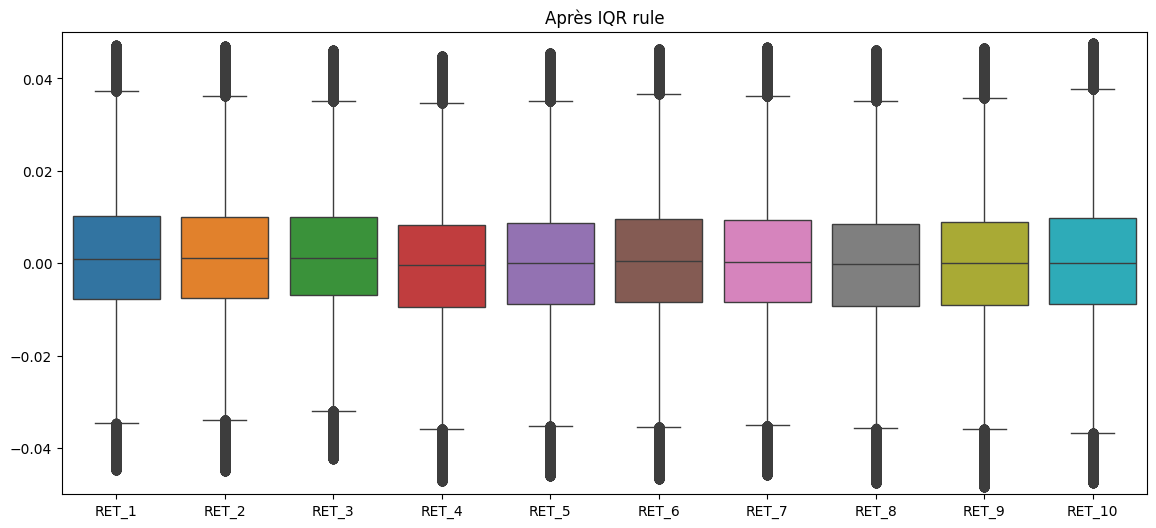

In [ ]:
features = ret_features + vol_features
X = cleaning_train[ret_features]

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
mask_iqr = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
cleaning_train_iqr = cleaning_train[mask_iqr]

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iqr)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")
plt.figure(figsize=(14, 6))
sns.boxplot(cleaning_train_iqr[ret_features])
plt.title("Après IQR rule")
plt.ylim((-0.05, 0.05))

The **Interquartile Range (IQR) rule** was applied to detect and remove outliers in the `RET_` features.  

$$
\text{Lower bound} = Q1 - 1.5 \times IQR
$$
$$
\text{Upper bound} = Q3 + 1.5 \times IQR
$$

$$ IQR = Q3 - Q1 $$

This method identifies values lying beyond **1.5 × IQR** from the first (Q1) and third (Q3) quartiles.  
After applying this rule, the overall distribution of returns remains consistent, with medians close to 0 and fewer extreme values.  
This confirms that the 37% removed observations were genuine outliers, allowing for a **cleaner and more stable dataset** while preserving the main statistical structure.

### IsolationForest Method

Nb lignes supprimées IQR : 18200, equivalently to 5.0% of total dataset


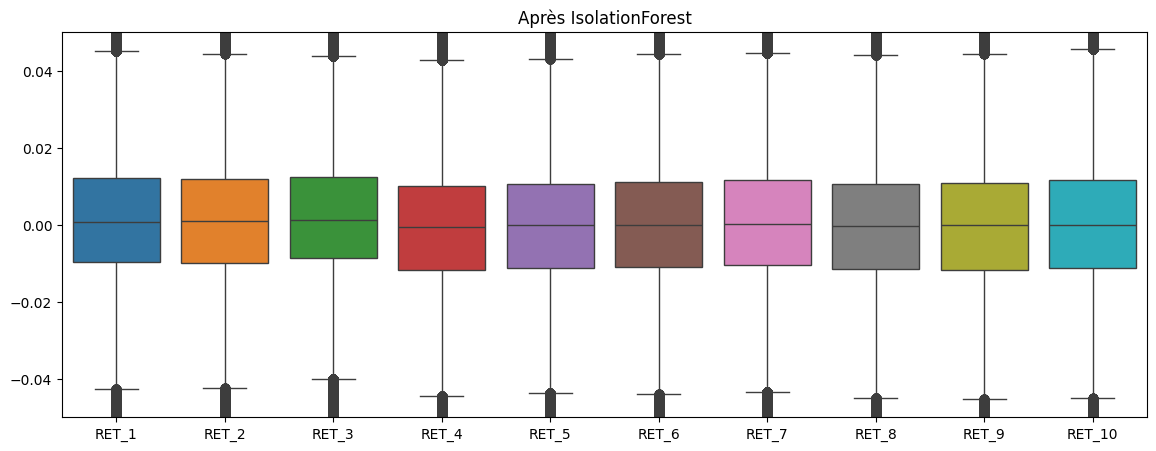

In [ ]:
# --- Méthode 2 : IsolationForest ---
iso = IsolationForest(contamination=0.05, random_state=42)
y_pred_iso = iso.fit_predict(X)
cleaning_train_iso = cleaning_train[y_pred_iso == 1]  # 1 = normal, -1 = outlier

nb_tot = len(cleaning_train)
nb_removed = nb_tot - len(cleaning_train_iso)
print(f"Nb lignes supprimées IQR : {nb_removed}, equivalently to {(nb_removed/nb_tot)*100:.1f}% of total dataset")

plt.figure(figsize=(14, 5))
sns.boxplot(cleaning_train_iso[ret_features])
plt.title("Après IsolationForest")
plt.ylim((-0.05, 0.05))

plt.show()

The **Isolation Forest** algorithm is a model-based method for outlier detection.  
Unlike the IQR rule, which relies on fixed statistical thresholds, Isolation Forest identifies anomalies by **isolating observations** that differ significantly from the majority.  
It works by randomly selecting features and split values to construct multiple decision trees, and the **number of splits required to isolate a point** determines how “anomalous” it is:  
- **Normal points** require many splits (they are deeply nested).  
- **Outliers** are isolated quickly (few splits needed).  

In this analysis, we applied Isolation Forest with a contamination rate of **5%**, meaning the model assumes roughly 5% of the data could be anomalous.  

After applying the method, the **overall structure of the `RET_` features remains stable**, with medians still around 0 and distributions symmetric.  
This indicates that the algorithm primarily removed **a small proportion of extreme or inconsistent observations**, improving dataset quality without distorting its core statistical behavior.  
Overall, the data is now cleaner and more consistent for subsequent modeling steps.


### Pearson Correlation's matrix

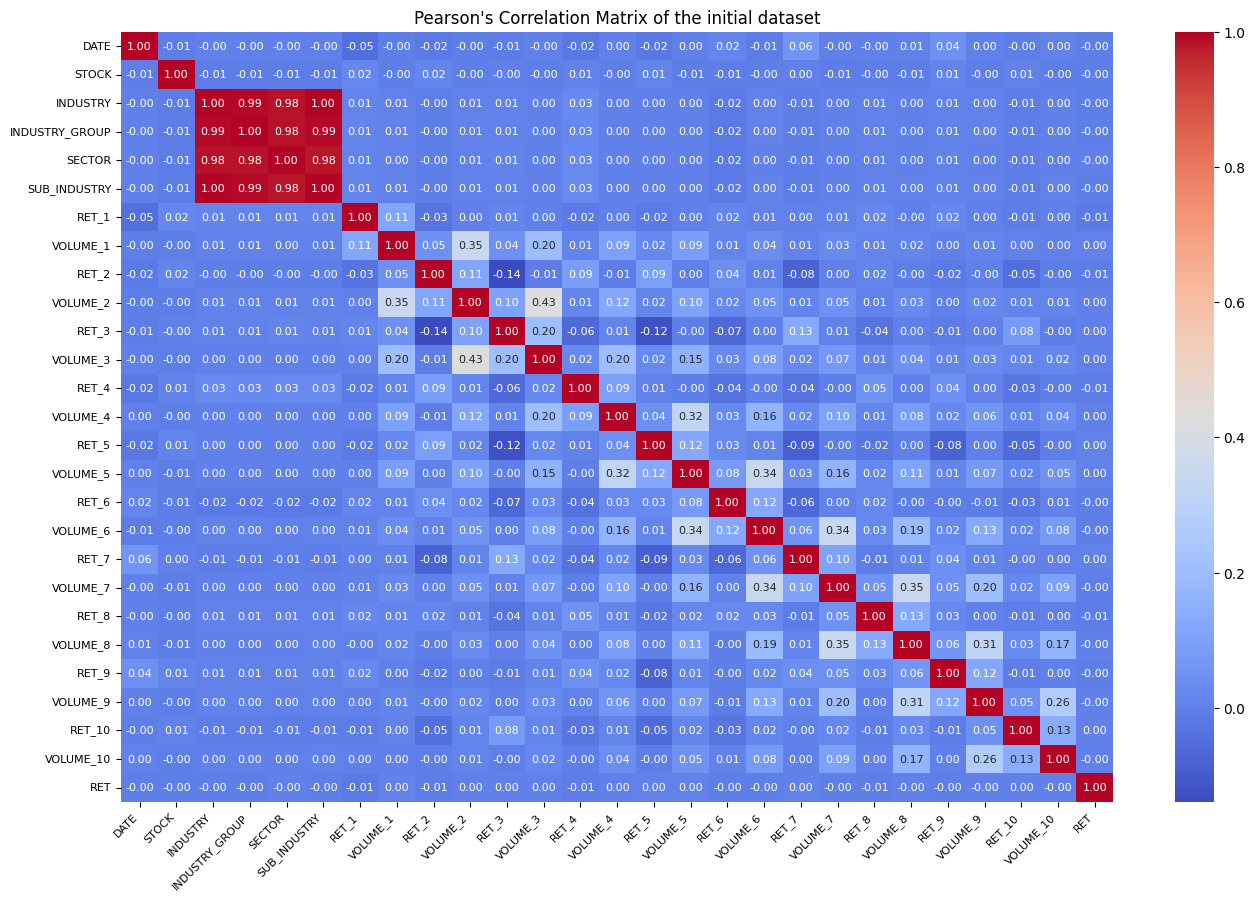

In [ ]:
plt.figure(figsize=(16, 10))
pearson_corr = cleaning_train.corr(method='pearson')
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Pearson's Correlation Matrix of the initial dataset")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

The **Pearson correlation coefficient** measures the **linear relationship** between two numerical variables.  

The formula is:

$$
r_{xy} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

This method assumes that the relationship between features is *linear* and that data is *normally distributed*.  
In our matrix, we can observe that some `RET_` features are moderately correlated with their adjacent days, which is expected given the temporal structure of returns.


### Spearman correlation's matrix

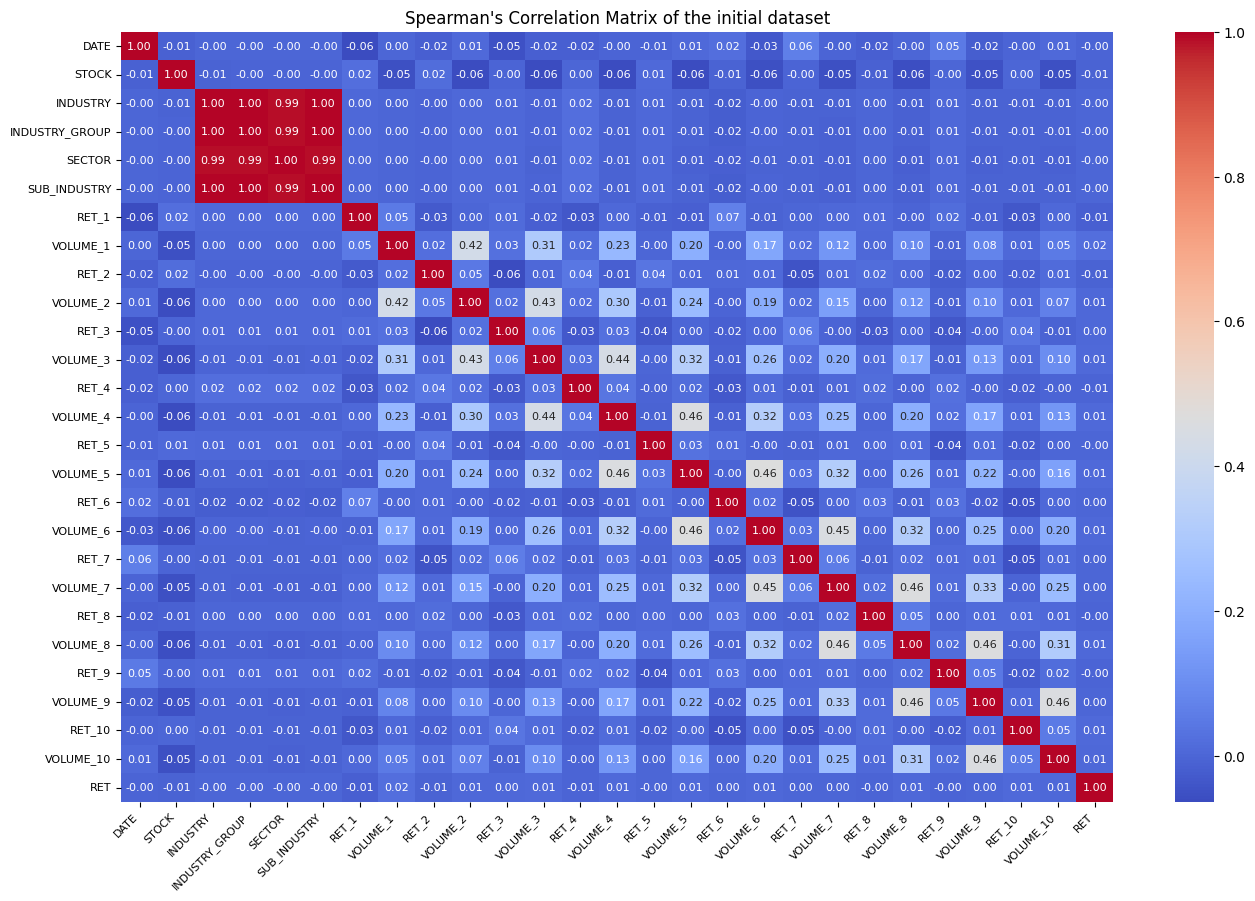

In [ ]:
plt.figure(figsize=(16, 10))
spearman_corr = cleaning_train.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 8})
plt.title("Spearman's Correlation Matrix of the initial dataset")   
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.show()

The **Spearman rank correlation coefficient** evaluates **monotonic relationships** (increasing or decreasing) between variables, regardless of whether the relationship is linear.  
It is computed on the **ranked values** of the data instead of their raw values.

The formula is:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

where **di** is the difference between the ranks of the two variables for observation *i*.

Unlike Pearson, Spearman is **robust to outliers** and **does not assume normality**, making it suitable when relationships are nonlinear or noisy.  
In our case, the Spearman matrix shows a similar but slightly smoother pattern of dependencies between consecutive `RET_` features, confirming their monotonic relationship over time.


# IV) Dimensionality Reduction

# V) Hyperparameter Tuning

Hyperparameter tuning : Commencer RandomizedSearchCV, puis affiner avec GridSearchCV.

# III) Baseline Model
**Implementation note (to avoid leakage):**  
We will compute and apply **per-feature medians within each training fold** (e.g., `SimpleImputer(strategy="median")` inside a `sklearn` `Pipeline`) so that statistics from the test/validation data are never used during training.

In [ ]:
n_shifts = 5  # If you don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5
ID,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,NaN,NaN,NaN,NaN,NaN
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398


In [ ]:
target = 'RET'
to_drop = []
to_drop = [f'RET_{day}' for day in range(11,21)]
to_drop += [f'VOLUME_{day}' for day in range(11,21)]
features = [col for col in frames[0].columns if col not in [target]+to_drop]
print(features)

for i,data in enumerate(frames) :
    frames[i]=data.drop(columns = to_drop)

['DATE', 'STOCK', 'INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'RET_1', 'VOLUME_1', 'RET_2', 'VOLUME_2', 'RET_3', 'VOLUME_3', 'RET_4', 'VOLUME_4', 'RET_5', 'VOLUME_5', 'RET_6', 'VOLUME_6', 'RET_7', 'VOLUME_7', 'RET_8', 'VOLUME_8', 'RET_9', 'VOLUME_9', 'RET_10', 'VOLUME_10', 'RET_1_SECTOR_DATE_mean', 'RET_2_SECTOR_DATE_mean', 'RET_3_SECTOR_DATE_mean', 'RET_4_SECTOR_DATE_mean', 'mean_RET_STOCK_WEEK_1', 'mean_RET_STOCK_WEEK_2', 'std_RET_STOCK_WEEK_1', 'std_RET_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1', 'mean_VOLUME_STOCK_WEEK_2', 'std_VOLUME_STOCK_WEEK_1', 'std_VOLUME_STOCK_WEEK_2', 'mean_VOLUME_STOCK_WEEK_1_/total_VOLUME_of_SECTOR_DATE', 'mean_VOLUME_STOCK_WEEK_2_/total_VOLUME_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_1_/total_RET_of_SECTOR_DATE', 'mean_RET_STOCK_WEEK_2_/total_RET_of_SECTOR_DATE', 'RET_10_day_momentum', 'VOLUME_10_day_momentum', 'RSI_SECTOR_DATE_10', 'Sum_ADL', 'abs_ret_1', 'abs_ret_mean_5d', 'realized_vol_20d', 'vol_ratio', 'rolling_vol_10d', 'rolling_vol_20d', '

In [ ]:
train = frames[0].copy()
X_train = train[features]
y_train = train[target]

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}
xgb_params ={
    "n_estimators":200,       # nombre d'arbres
    "learning_rate":0.1,      # taux d'apprentissage
    "max_depth":5,            # profondeur des arbres
    "subsample":0.8,          # sous-échantillonnage
    "colsample_bytree":0.8,   # proportion de features utilisées par arbre
    "random_state":42,
    "eval_metric":"logloss"   # évite le warning scikit-learn
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
models = [xgb.XGBClassifier(**xgb_params), RandomForestClassifier(**rf_params)]

for model in models :
    print(model)
    scores = []
    splits = KFold(n_splits=n_splits, random_state=0,
                shuffle=True).split(train_dates)

    for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]

        local_train_ids = train['DATE'].isin(local_train_dates)
        local_test_ids = train['DATE'].isin(local_test_dates)

        X_local_train = X_train.loc[local_train_ids]
        y_local_train = y_train.loc[local_train_ids]
        X_local_test = X_train.loc[local_test_ids]
        y_local_test = y_train.loc[local_test_ids]

        X_local_train = X_local_train.fillna(0)
        X_local_test = X_local_test.fillna(0)

        model.fit(X_local_train, y_local_train)

        y_local_pred = model.predict_proba(X_local_test)[:, 1] #proba de prédire 1 True
        
        sub = train.loc[local_test_ids].copy() # on garde les lignes du train qu'on va agrémenter de leur proba de predire 1
        sub['pred'] = y_local_pred # on agrémente celle colonne de préditiction
        y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values 

        score = accuracy_score(y_local_test, y_local_pred)
        scores.append(score)
        print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

    mean = np.mean(scores)*100
    std = np.std(scores)*100
    u = (mean + std)
    l = (mean - std)
    print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})\n')

Fold 1 - Accuracy: 50.40%
Fold 2 - Accuracy: 50.80%
Fold 3 - Accuracy: 52.01%
Fold 4 - Accuracy: 50.92%
Accuracy: 51.03% [50.44 ; 51.63] (+- 0.59)

Fold 1 - Accuracy: 51.12%
Fold 2 - Accuracy: 50.39%
Fold 3 - Accuracy: 53.32%
Fold 4 - Accuracy: 51.92%
Accuracy: 51.69% [50.60 ; 52.77] (+- 1.08)



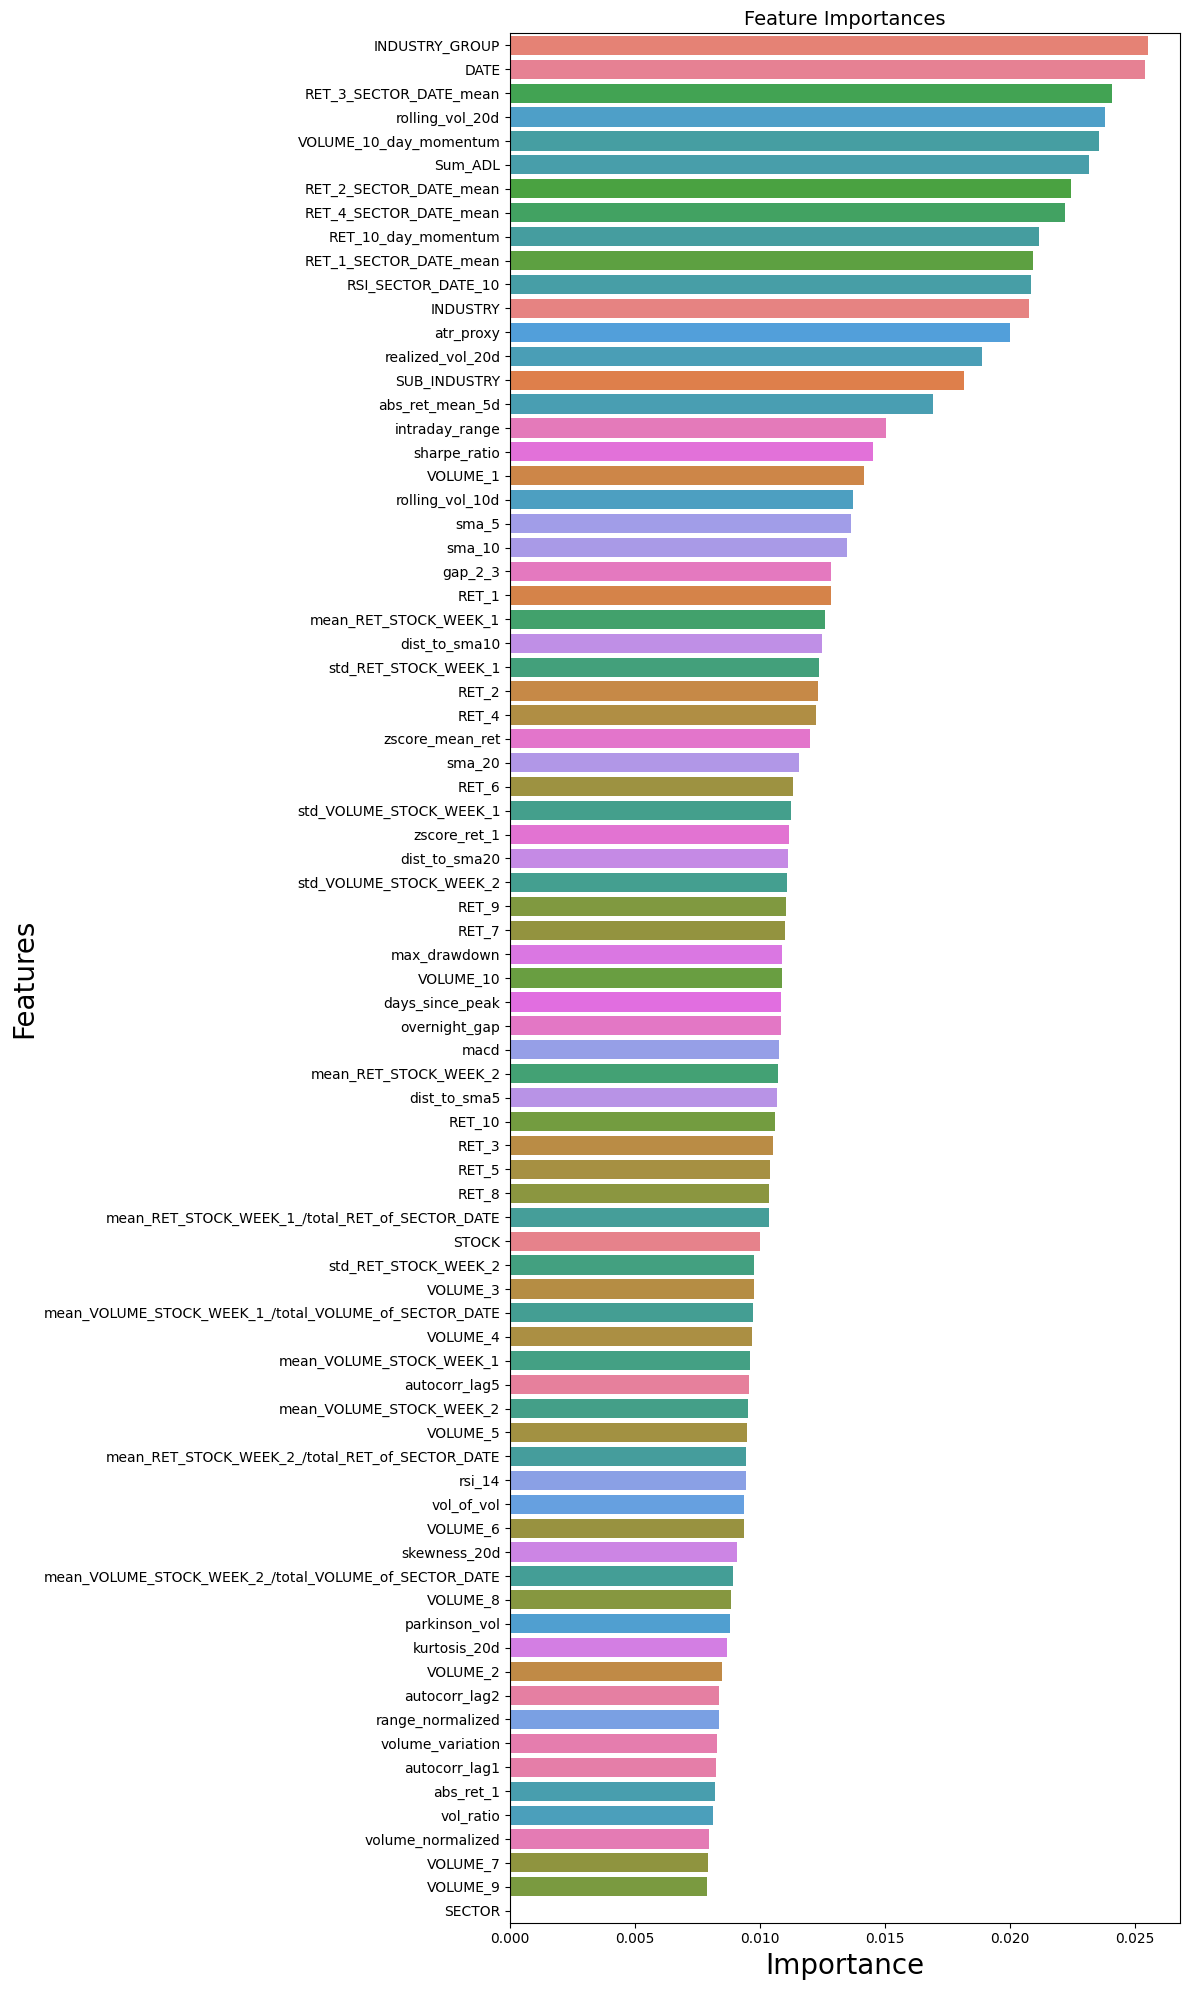

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase figure size (width=12, height=8 for example)
plt.figure(figsize=(12, 20))

feature_importances = pd.DataFrame(
    [model.feature_importances_ for model in models],
    columns=features
)

sns.barplot(
    data=feature_importances,
    orient='h',
    order=feature_importances.mean().sort_values(ascending=False).index
)

plt.title("Feature Importances", fontsize=14)
plt.xlabel("Importance", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.tight_layout()
plt.show()


# Ensemble methods

# Model Evaluation & Comparison

# Output for challenge submission

In [ ]:
test = frames[2].copy()
X_test = test[features]

rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)

model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target_feature

submission.to_csv('test.csv', index=True, header=True)